In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
    
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 5HK8ST8k 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

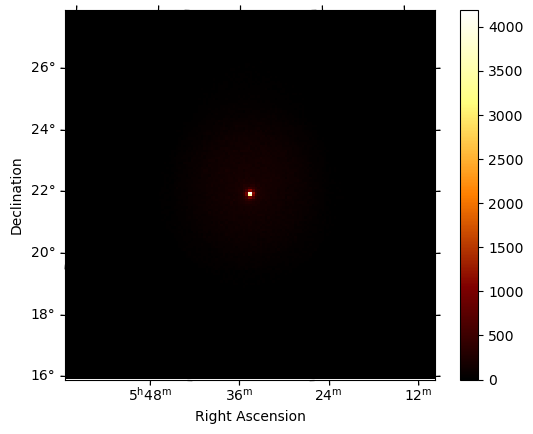

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
shift = +0.1
tilt = 0.015


N = 900
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True




In [5]:
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass


0
shift:, [0.06838823], tilt: [0.03461683]
8.673354045778349e-13   8.615991942440414e-14   2.3254969495514684   0.07274349584708015   1.0008268630122437   0.002067031778903387   -0.0018443835112183112   0.0019577478386187375   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.26335116453834 1.1861184601504509
norm 0.815326350430646 0.42731963946212387
norm 1.1963548484812154 0.22852455976038455
norm 1.0354305405207807 0.19484665108223995
norm 1.2034753774074756 0.2028395545815405
norm 0.6468111807418946 0.19364710177013714
norm 0.8360734980940904 0.21812675223125375
norm 0.6109971630585809 0.2259003692667643
norm 1.4785965125435179 0.2935489041408438
norm 0.6743318696622137 0.27095865660129326
norm 1.271383284682128 0.36180378138700703
norm 1.0416775356464283 0.40368586436639997
norm 1.0147420266444938 0.4591828154533548
norm 2.1111801447249774 0.630920644443851
norm 0.3014036615533703 0.4569321517736698
norm 0.8257451980179238 0.6240033280114547
norm 0.4299908331667102 0.

norm 0.7105012522327928 0.286129596199853
norm 1.2542427520856203 0.37562904181558177
norm 0.5904107524076104 0.3703120597116909
norm 0.8545713710103062 0.4379678392283641
norm 1.6891128018145416 0.6458128870612778
norm 1.0563063257275374 0.6061202841248771
norm 0.6975987039523733 0.6190185268941819
norm 0.0908565412131745 0.5022475063372666
norm 1.0 0
8
shift:, [0.06746977], tilt: [0.02884139]
1.0925039264706075e-12   8.781291196053763e-14   2.2909638450394962   0.05779488421575664   1.0004133355551332   0.0020673706220058334   0.002711902702323959   0.001965965121604332   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7364762550678958 0.9741667103764617
norm 1.2300447897460605 0.37255644901193424
norm 0.9292018535267755 0.1789176306202165
norm 1.0752170729832942 0.15976405145154796
norm 0.8925955349071093 0.15759940862852376
norm 0.8765158095844866 0.16336218766689473
norm 1.0702957613238628 0.17876912231581565
norm 1.2470627047537866 0.20660314595072607
norm 0.688852

norm 0.9091965131950179 0.20677989730514135
norm 1.1608291206230426 0.1811508005912893
norm 1.0249149273983735 0.18764459151798338
norm 0.8886254222550335 0.1888245895566659
norm 0.874736343389468 0.2027176414799541
norm 0.9878840908284422 0.22777616140855272
norm 1.1430622261312782 0.25808021136764053
norm 0.914827028000993 0.27608948696315533
norm 1.5329115546600738 0.36541503371105427
norm 1.0756797729785823 0.3789625537371568
norm 1.3482880720997352 0.4654829719482562
norm 0.7902601422113891 0.45922903512981694
norm 0.6247628234714958 0.4786498895617987
norm -0.17087897526952578 0.32145998016992755
norm 0.3379171106135341 0.5492109213758826
norm 1.9741267729328258 1.1212922115752673
norm 1.0 0
16
shift:, [-0.02455692], tilt: [0.01085608]
1.1419721585256319e-12   9.51668946400938e-14   2.3141538892293814   0.059165956421255966   0.9970000392221261   0.002062818625322906   -0.002651572655438251   0.001960116559412503   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.40

23
shift:, [-0.09050969], tilt: [-0.01114661]
1.1798549790770897e-12   9.824001693062508e-14   2.3695277612072503   0.06202589398865079   0.9974886638335654   0.0020466140251969747   -0.0011474471707535558   0.0018556038294882775   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3271196466405935 1.0142595677345625
norm 0.8831784637696376 0.3666559446680639
norm 1.2335475274356391 0.19923119022879687
norm 0.893134592516893 0.16800129577685088
norm 1.0005562298812773 0.1740618272692091
norm 1.2755688845327926 0.18778827096773312
norm 1.0033380871577213 0.2003118353783575
norm 0.9117138929959164 0.22058042258381216
norm 0.4286310941551418 0.20698915116906494
norm 0.48101440411922675 0.2266085894156525
norm 0.9770346135762114 0.3124564486342519
norm 1.1665756232922184 0.36442351768904746
norm 1.0892694821401963 0.3947278307519328
norm 1.6802331940223294 0.5498509493471905
norm 1.150681563339061 0.523769553162571
norm 1.285921185865534 0.6045403621918791
norm 1.50150472371245

norm 1.0626378707347992 0.2608430901033084
norm 0.8788125889381005 0.2650659888192771
norm 1.008339851209702 0.2946085415561941
norm 0.7408139074107449 0.33267979013656646
norm 0.3688534120211413 0.2961789939697364
norm 0.802518015842086 0.394234804766327
norm 1.888747756430973 0.6031473350873744
norm 0.9398881462434662 0.5491327143429585
norm 1.2158507188494303 0.6899899502563347
norm 1.0 0
31
shift:, [0.00995176], tilt: [0.0148308]
9.748913807309834e-13   8.952709284101739e-14   2.276332911060149   0.06264661363455884   0.9994533799275852   0.0020658746093121737   0.0015628057326358218   0.001964467725981556   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7955438572133857 1.1543111381231381
norm 1.7551602553261363 0.4481584331353409
norm 1.1768066163251842 0.2172714364920573
norm 0.6158031058896487 0.16997044088881247
norm 0.7706245362687174 0.1763792911436187
norm 1.412691059293669 0.19750997541712353
norm 0.9695799280053702 0.19952959932615513
norm 1.00273826156917

norm 1.9915556064176847 1.0948556675113656
norm 0.40416963269539985 0.34987313440525464
norm 0.9288932520962443 0.1992840575466611
norm 0.9583828347101192 0.16822320040226482
norm 0.9757935760229627 0.17117502082550198
norm 1.1392308551431722 0.18093151476308691
norm 1.147979601709335 0.1927560578989332
norm 0.9629967376725357 0.1993850638304208
norm 0.9427013521018229 0.21878679176825253
norm 1.306209482980701 0.2607371358188767
norm 1.0538347495480904 0.2763185259942918
norm 0.5386503251998614 0.2589189894300683
norm 1.2859496651138889 0.3754002610253638
norm 1.315749217560822 0.4348339739875086
norm 0.523679068811062 0.36501487843758096
norm 0.8201803147771496 0.4760525205529755
norm -0.29247886407337587 0.033797369641543513
norm 1.8265195615470644 0.9039655465288878
norm 1.0 0
39
shift:, [0.15095402], tilt: [0.00856784]
8.640383343823344e-13   7.993440215976406e-14   2.344476375615343   0.06851195057501897   0.9986902691565821   0.0020646079241890994   -0.0023580577463610023   0.00

norm 0.31866329613421496 0.5869948527741619
norm 0.8218228021799793 0.7668602967426732
norm 1.0 0
46
shift:, [-0.03209106], tilt: [0.02631025]
1.0709176549150471e-12   9.574280026715705e-14   2.308856435355247   0.06387996251816748   0.999242686120494   0.002065317527665781   -0.002416715318027616   0.001958430610571327   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.4821579450598719 0.8248162793420641
norm 0.9445654433770732 0.3845104643615526
norm 0.95562847303528 0.1984618637895827
norm 1.179912215963223 0.18117416133602032
norm 1.1439222237719102 0.1812957525190963
norm 1.0757421726098348 0.18891929445033256
norm 0.8739449173501217 0.19219090935117342
norm 0.8373918676459977 0.20766240654915336
norm 1.342394807352873 0.25255292358457937
norm 0.4697110490151658 0.22990426996033952
norm 0.6950930167863529 0.28613437289773014
norm 0.8567227525391433 0.3191687707468514
norm 0.7074270526425285 0.3590723751965382
norm 0.6278424207131543 0.40968156135658523
norm 1.773347

norm 1.0411610191057286 0.20227304993675296
norm 0.727691733057453 0.20328576193912457
norm 0.8999479104009805 0.23946723346766444
norm 1.2458325451395493 0.277061970380255
norm 0.7373713640720782 0.27900368333550657
norm 1.1622663007117053 0.36418557198663953
norm 1.7823077545790202 0.49181208054700765
norm 1.0415579152843275 0.4481759439233567
norm 0.7251556142371303 0.4700025502965807
norm 0.5505978985731367 0.45844117015829716
norm 0.6118578842365497 0.5785272719098222
norm 1.0 0
54
shift:, [-0.1553238], tilt: [0.00658035]
1.1494999408657972e-12   1.1848113942690054e-13   2.2676646805611207   0.06144952308323627   0.9995651551389507   0.0020681846353157807   0.0011911894422796147   0.001964224651832579   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4199319977182159 1.2432141707815436
norm 0.3841509471557077 0.4178666436589192
norm 0.8418124343108433 0.22084779604343666
norm 1.059048081625267 0.1951473799609117
norm 0.8952542119190621 0.19017324282935746
norm 1.179

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.018769338590763053 0.9197944386495946
norm 0.35276604357594316 0.3813779298011235
norm 1.0975029807415408 0.20912490700262615
norm 1.05633281061985 0.1788266281754104
norm 1.136493818353726 0.17537832577751097
norm 0.6835280259668339 0.17180993506186937
norm 1.0195582160357077 0.1877149106521422
norm 1.277413519987558 0.21113367406699268
norm 0.980051986996185 0.21070531321926714
norm 0.9719753702743963 0.22846148903418625
norm 1.095531170157975 0.26234392301662773
norm 1.116939737668376 0.29513393713526187
norm 0.5949029828745799 0.2877443458619497
norm 0.7907250537168745 0.35400713012817564
norm 1.5945501483981126 0.4786043298672631
norm 0.9513394207449508 0.5091384012794837
norm 0.42050902432880194 0.4246761762450805
norm 0.8593422059550179 0.6532751157267126
norm 1.0 0
62
shift:, [0.04020705], tilt: [-0.01793569]
1.023662931662595e-12   8.829359238425776e-14   2.3551744470810196   0.06140067394955101   1.000262833286996   0.002067

norm 1.0477338187802654 0.537166702368895
norm 1.596867531481536 0.7264994379334353
norm 0.40425633541462136 0.6458789997262819
norm 1.0 0
69
shift:, [-0.06513369], tilt: [-0.00748399]
1.358088843610703e-12   1.1412514153294933e-13   2.3469917550748414   0.05795606097388196   1.0012259820413174   0.002071133291521978   0.002296789698332475   0.0019661980621326135   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3312497939979557 0.9023373602360388
norm 1.0467271152775386 0.33961901005121303
norm 1.0219751238927903 0.1768896752134059
norm 0.9592011615893837 0.15270347139310314
norm 0.8346025056698263 0.1536586312870999
norm 1.3372310776611236 0.1743398816016618
norm 0.8291924295358482 0.17071797231156832
norm 1.0008438209478672 0.19573472381877036
norm 1.1667779335367916 0.22114959472172022
norm 0.743795533504413 0.2218531994488155
norm 0.6796442420825559 0.24571030483020026
norm 1.2288701649120581 0.3335670605287243
norm 1.4260090543971389 0.4005786939878668
norm 0.78617

norm 0.8861661297878836 0.2098025291261089
norm 1.35082254390468 0.2519147550234162
norm 1.2792576972468368 0.2764815158676331
norm 1.0533755527858855 0.28728629879642503
norm 1.0530726058026856 0.327135620830838
norm 1.318524000861918 0.388422275703697
norm 1.1471668414131782 0.44436274898220723
norm 0.5576411129107283 0.4125890701306061
norm 0.5995705320077247 0.4531574784180939
norm 0.368998081572605 0.5315753829968324
norm 1.1487541223417326 0.7202494403251587
norm -2.1895309955916344 0.5772653392603821
norm 1.0 0
77
shift:, [0.17296507], tilt: [5.91582568e-05]
8.893608112625142e-13   7.659746925059528e-14   2.337131310718326   0.06158289444313163   1.0030237482548827   0.002069092772797894   0.002010950182693122   0.001961352919240693   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8094625481643758 0.8117374929146223
norm 0.0672019785249265 0.33824350440497
norm 1.067659990266505 0.20371057289642894
norm 1.108062018329096 0.17740004732888828
norm 0.80510717119305

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.25625766887749024 0.814805586572147
norm 1.1725055268560043 0.3835571097347702
norm 0.9558225336620463 0.19097887145295278
norm 0.9362091084290851 0.16621621580419468
norm 1.2435080149379052 0.17609877285937026
norm 0.923208981021309 0.17657658051206498
norm 1.0394321478815298 0.1892216954478424
norm 1.0871429275833244 0.21415610200840188
norm 0.6387705818004566 0.2131737874541319
norm 0.7187286737475894 0.2434554187739128
norm 1.266780579154134 0.31731682922043297
norm 0.9883317264949267 0.32957135632513634
norm 1.3861758533654425 0.39054773773004403
norm 0.6324429504820224 0.42144532507310745
norm 1.2758521229614432 0.5132852801015189
norm 0.8612415141727943 0.535342207198119
norm 2.226147179243602 0.9534864834601899
norm -0.3751558728721405 0.47238280283720646
norm 1.0 0
85
shift:, [0.08443205], tilt: [0.02440332]
8.498433416117127e-13   8.09644275319804e-14   2.218600562331187   0.061148322603763114   0.9995703521771911   0.002065

norm 2.036101628298601 0.5679256469751086
norm 0.9868683485235925 0.48799330803931434
norm 0.7398889580353631 0.5106906345052667
norm 1.0 0
92
shift:, [-0.14965334], tilt: [-0.02244082]
1.0686336770687504e-12   1.158141174588714e-13   2.3104967884919505   0.06715931572674384   0.9989858729119807   0.0020668868820630975   -0.0013278844058278087   0.00196098713439809   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.947692023609517 1.255480424088444
norm 0.5916793962490735 0.4449273028733647
norm 0.7194186088804588 0.2253081116902283
norm 1.2895044353442109 0.2050784496710621
norm 1.2025597346933634 0.20431451978918264
norm 0.8690624968524965 0.2015088699328858
norm 0.9824953358151655 0.2137945334591008
norm 1.0154558592676708 0.23712135307661866
norm 0.8177304043671094 0.2405461004563592
norm 1.3281445333092996 0.3066951134112439
norm 0.6633977850717362 0.2925727719644243
norm 0.4476553469356744 0.2966008804544948
norm 1.2036198242791118 0.41466934703022523
norm 1.0779226

norm 0.9742016998698773 0.20058202819845405
norm 1.023519073328676 0.21698139211289313
norm 0.8676313132263082 0.23621362124556355
norm 0.915840896410193 0.26738841682008874
norm 0.8885256906005117 0.30829305274467167
norm 0.9836466353237758 0.3517814779563372
norm 1.3552030934073236 0.4627738776248622
norm 0.8610621255641508 0.4440484115866905
norm 1.0778153579411507 0.5865113151279499
norm 1.0026689433382547 0.5884025036492397
norm 0.2426452172263301 0.4786329531801664
norm 1.0 0
100
shift:, [-0.10425942], tilt: [0.01838228]
1.096655886092597e-12   9.926761688063917e-14   2.2623241429527865   0.06026303030365506   0.9997263381850658   0.0020652151462342942   -0.0011388992106146347   0.0019593548126938917   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.317563862422154 1.2429036965193265
norm 1.0223815289764009 0.41795413714374313
norm 0.7316375545356408 0.20212361444998816
norm 1.1776711201792578 0.1873486789577395
norm 0.958695498557386 0.18210038863649858
norm 0.951

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.39831457889687544 0.8600634560196134
norm 1.4875324161343073 0.41637046461508276
norm 0.9704703749401483 0.19981442016552478
norm 1.1910951704424944 0.17854097722718443
norm 0.9805203358290743 0.17472642677360556
norm 1.112521044804844 0.18552501001335447
norm 0.5589711006911658 0.17903673586197352
norm 0.8268284073082023 0.2046646538318817
norm 1.2196358583390765 0.23713570344378068
norm 0.9438262524529881 0.24846606212892852
norm 0.7340080207904596 0.2725082627131544
norm 1.0229101527109805 0.3157812055512998
norm 1.2347112909870381 0.37822817171197093
norm 1.3240632317772345 0.47652429601671475
norm 0.7527245644261893 0.44200636212381544
norm 2.078934818967573 0.7131598620904982
norm 0.17107819731948662 0.4522889255339703
norm 1.2266510783653068 0.8757849405711795
norm 1.0 0
108
shift:, [0.15456799], tilt: [-0.01436055]


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.0245361458386302e-12   9.181392067434922e-14   2.3696215218277885   0.059132946183372226   1.0011308921133848   0.0020707566963393876   0.0017667717620038484   0.0019641636234818943   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.4494061128999606 0.8358086097212196
norm 0.8779996175732026 0.34101158127996034
norm 0.9425800648976193 0.17922163158672766
norm 1.1043508111167417 0.16336956081141424
norm 1.021792289337913 0.16309534858701819
norm 0.8638913959086673 0.1684088917514535
norm 1.0216493317700912 0.1843630376734092
norm 1.2359881487730415 0.21501066855488155
norm 1.0647567661532074 0.2288099238014531
norm 1.1171802934408956 0.25994046222912337
norm 0.7462368009358477 0.25945187961627597
norm 1.264977671394786 0.35525322415311494
norm 0.3753214290639491 0.3049776349724106
norm 0.9293974823462978 0.4397068637580219
norm 1.1998010845163412 0.5093390655782939
norm -0.045718928917650906 0.3258080399591849
norm 2.2291247951173094 0.8817370011389962
norm 0.8200610634

norm 1.1152676237217853 0.25259152055416495
norm 1.4990590398269423 0.2965404825106421
norm 0.424609701047949 0.26129230891272204
norm 1.4366309269651774 0.35577431883026356
norm 1.0218427223993545 0.3765927828683205
norm 0.23740739090410873 0.30249839113110477
norm 1.1527286426155507 0.5394956321057328
norm 1.4465771160764145 0.6311633656657154
norm 1.0 0
116
shift:, [0.00543219], tilt: [0.03098042]
1.1330605858986819e-12   9.744378133859299e-14   2.3416211552743587   0.06214131115380866   1.0013948684793843   0.002056299134452803   0.0014953630235484783   0.0019474325264921106   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.49994143835535215 0.8445085494636487
norm 1.5450242620286077 0.3722734959285191
norm 0.8838200025406638 0.1828327689019962
norm 1.2681692397272655 0.1715307350919985
norm 0.848223373855127 0.16159961841750997
norm 0.8743839122157723 0.17109128004864715
norm 1.013420154300121 0.1870952351896082
norm 0.835206937658472 0.20463024919757875
norm 0.8985

norm 0.5219314818157443 0.41094571162742183
norm 1.1277669377553758 0.2221206315361849
norm 1.1718068972517688 0.19070084336160373
norm 0.8366987965710502 0.18443000938264897
norm 1.2670400636576724 0.20571577886178302
norm 0.6753139393865596 0.1971358046357726
norm 0.7787157148039714 0.21455517248608572
norm 1.127313058069317 0.25277352289434885
norm 0.9838780503624216 0.27898017994826646
norm 1.4457087823187684 0.33422772493224917
norm 0.8743580565753726 0.34380983547995436
norm 0.9399424402175648 0.3657627243820364
norm 1.182172755263624 0.4547743822299077
norm 0.8988055676935889 0.46451133048433024
norm 0.5602952713807412 0.4532013467617812
norm 0.5080282107022644 0.458387273906978
norm 1.9520833148762307 0.9189272196872337
norm 1.0 0
124
shift:, [0.27241831], tilt: [0.01959762]
7.929889081904852e-13   6.995912586297092e-14   2.1867471541288843   0.05517075444443616   0.9991457514483494   0.002061921943347437   -0.0011033139576731863   0.0019557588895948983   
norm 1.0 0
norm 1.0 0

norm 1.2590218872718375 0.6468210926883358
norm 0.811540837277972 0.6757242579268794
norm 1.0 0
131
shift:, [0.1125725], tilt: [-0.00376758]
1.0225819310941766e-12   8.694509890444813e-14   2.358464826200804   0.06091438390879457   1.0021261200743794   0.0020696971169809042   0.002028239428739296   0.001962938619418371   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.616419598690454 1.088538317923214
norm 0.4815203189586333 0.34117790416561017
norm 0.9219408510628624 0.18509192794029908
norm 1.054413453393493 0.1641759097581991
norm 1.1023169661932692 0.16743441449474838
norm 0.9361893830818941 0.17022566993249486
norm 1.0333019038343658 0.19117952416639755
norm 1.2463755290383003 0.2154096295854536
norm 0.8531428355426328 0.21893692129362816
norm 0.49041626445743647 0.21920536659172088
norm 0.9028927559743191 0.27845083836420964
norm 1.7254188675187447 0.3800905534726527
norm 0.26471476771318025 0.2759245858316525
norm 0.5668823303580425 0.38497624336434794
norm 1.7577

norm 0.9090025350630094 0.20771497832543329
norm 1.1463972258571153 0.23790035501695006
norm 1.5308358321914857 0.2810872539445189
norm 0.6994069222786496 0.26413715762009365
norm 0.9050920185948325 0.2971548165448078
norm 0.7810612286923069 0.32485898245444106
norm 1.231705337693178 0.42778744295650506
norm 1.1471943032935306 0.4556311359235894
norm 0.7685812890850089 0.43260979839303754
norm 1.2283476134905067 0.6034704383067662
norm 0.6248492700892457 0.5632142845991271
norm 1.0 0
139
shift:, [-0.01950654], tilt: [0.01190053]
9.99054316856464e-13   9.449260520649842e-14   2.3097460323290098   0.06734810117630986   0.9994629055576786   0.002063636515911865   -0.0007835195613772541   0.0019552463580000306   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.32577245009098815 0.9746098032065383
norm 0.898087663894191 0.4010696906955452
norm 1.0892826057877683 0.21037933282492977
norm 1.0009108493001124 0.18191123420274488
norm 1.1666078981434482 0.18893652026896093
norm 0.9

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3248177760678516 0.991606503540487
norm 0.7129475409364804 0.4082054390564948
norm 1.1296802780269066 0.2095044452762927
norm 1.1233352958849512 0.18145109715924246
norm 0.7269614341626187 0.1699529983327244
norm 1.1210129666320272 0.19332597026954113
norm 0.8320239956230882 0.19163564655254986
norm 1.112294056780575 0.2224441009513508
norm 1.1306876677239721 0.24251675379584842
norm 1.06467738348519 0.2701376689253245
norm 0.9970544471236111 0.300799591317884
norm 0.7361239903596698 0.30189265958526035
norm 1.3531182726447004 0.40317224147349656
norm 1.2278155948711325 0.43301864839638826
norm 1.1278146120776906 0.5170272081266739
norm 0.5805482309535938 0.444096924013068
norm 1.0170379700236456 0.6176490984052311
norm 0.17537882269764993 0.48245190113551273
norm 1.0 0
147
shift:, [0.15405325], tilt: [0.02408279]
8.509431164100833e-13   7.991884638851352e-14   2.27285620453169   0.06281784273490443   1.0013482189157694   0.00206882284

norm 1.0254634154150606 0.7661383002641411
norm 1.215703464664135 0.836011989322398
norm 0.06231533807050618 0.5778056082186823
norm 1.0 0
154
shift:, [0.08792926], tilt: [-0.01114834]
1.0124758096211259e-12   8.421091495699298e-14   2.381009140209657   0.061500209107943994   1.0012058461980404   0.002067920282923988   0.004555034044294243   0.0019672835657274317   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7714453521655689 0.9368458667094597
norm 0.909100252417634 0.3635609139800411
norm 0.9649757508987887 0.18968747309454934
norm 0.9266897752190306 0.1654147242015722
norm 1.023195959471924 0.16915688638114237
norm 0.8868131168104055 0.17569330582499976
norm 1.1896414809845268 0.19808207788394494
norm 1.1443978363573513 0.2127894635552525
norm 1.1716197514073654 0.24956540634027324
norm 1.0407810939279718 0.2615864413450751
norm 0.46746455448264607 0.25704467073132914
norm 0.9130631378590233 0.34415577287811
norm 1.6208981285854467 0.47443057636646907
norm 1.153721

norm 1.0074541135054118 0.19346943326157123
norm 0.9534408271829417 0.21155341511304063
norm 0.8463953302388462 0.2250359668640511
norm 1.0942422623271986 0.284194435716522
norm 1.2121127025732026 0.3342836032792833
norm 1.3198811061643687 0.3914611484917421
norm 0.406421190000916 0.3363378432972026
norm 0.4240202585381893 0.3991864350769271
norm 1.2880850284412009 0.6091316203801336
norm 1.562360001890959 0.7047045733551033
norm 1.2638906685363307 0.8821342874053997
norm 1.5975251433407605 1.3143405505427668
norm 1.0 0
162
shift:, [0.02188448], tilt: [-0.01536358]
1.0786799125036772e-12   9.295209994037968e-14   2.3551761211532094   0.060449288076067274   0.9949097739428038   0.0020611366806279354   -0.0012231843031789264   0.001964374796483952   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.3018410750293135 1.0877892834676917
norm 1.372881681619878 0.3968070630977929
norm 1.0800911601849041 0.19334730836745972
norm 0.7294925208866869 0.15874421197380284
norm 1.014721

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2685742739825665 1.0815928695995074
norm 0.6485313238345782 0.39087550731897813
norm 0.880646680600115 0.20381317251616732
norm 1.2306824588108745 0.18536751252360267
norm 1.1461664540295393 0.1860361364756412
norm 1.010509988486947 0.19082837398409525
norm 0.6267701179254004 0.18476952423440324
norm 1.23556969959358 0.23220116152035578
norm 0.9628075032481307 0.2391758485944639
norm 0.758051621774473 0.24333944080997544
norm 0.9959793255557855 0.29765377963442974
norm 0.9727824613421937 0.32742628124097295
norm 0.7586182352416303 0.36498402853402573
norm 1.1438978861436184 0.46342401998004923
norm 1.8203361176652333 0.6209292073907884
norm 0.5556048003141039 0.4622396086129412
norm 1.6415991168470068 0.8048522012072116
norm 0.7361011691585845 0.844226098879853
norm 1.0 0
170
shift:, [-0.02551501], tilt: [0.00417545]
1.018958988064308e-12   8.903375081429935e-14   2.20804372416559   0.054221965452969   0.9964845356206996   0.0020620189

norm 1.219676776738908 0.660397401426766
norm 1.3741730448397473 0.8815131334373622
norm 0.7731599109518157 0.7863351506339885
norm 1.0 0
177
shift:, [-0.12791375], tilt: [0.00198684]
1.1253999373732758e-12   1.0171555772182187e-13   2.2518237150800107   0.05877726405120949   1.0017036970335234   0.0020673184723005176   -0.0017721880997535126   0.0019565191984654185   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4099633683934396 1.1215444476819665
norm 1.2839569354076323 0.4420948692622809
norm 0.6931360969105854 0.20449613957733515
norm 1.2532905787781874 0.18625185569169542
norm 0.7622461872728743 0.1738580438759791
norm 1.2564274969527167 0.19324119586177055
norm 1.0436654044183784 0.19466060806858
norm 1.0184679121509705 0.21335132030745127
norm 1.097761350871525 0.23484479715563286
norm 0.5150556870283419 0.21789437649635418
norm 0.8806671821735502 0.2605003304766845
norm 1.0305175196244014 0.3133423596399415
norm 0.9648017641070561 0.3388748157421391
norm 0.7644

norm 0.8475678628710636 0.19410333530505644
norm 0.9710561104988867 0.2065394245401936
norm 0.6729431558226984 0.21243199473018792
norm 0.8942647577717695 0.2517657591270641
norm 1.208515928460189 0.3076689361706279
norm 1.379362664672925 0.3484130776481682
norm 0.44495371758585966 0.3088338636484188
norm 0.9291516858474956 0.40478383993963846
norm 1.8030084702503806 0.5835025660976656
norm 0.9291797275035981 0.5376586950197322
norm 0.7935677781804272 0.64152861955601
norm 0.8378086193122604 0.757502564815282
norm 1.0 0
185
shift:, [-0.21019986], tilt: [0.02306482]
1.217126963550741e-12   1.3601148812494585e-13   2.2684963516388397   0.06511934717468172   1.0001812425424097   0.0020705643173025774   0.0004580135856981428   0.001963342547353023   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7050425982993079 1.1158879361062557
norm 1.2967660732371897 0.446144145949349
norm 1.1591820072701018 0.2233652599609667
norm 0.8925498610747651 0.18646079017434128
norm 0.937874722

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.32604248318844703 0.863499473174497
norm 0.2607048274505078 0.33417318671679813
norm 1.0473920259261715 0.19290439350913952
norm 1.0450172136993687 0.1686328010865644
norm 1.1794844612619775 0.1753407509244442
norm 1.0797470976560224 0.18424643642856536
norm 1.0722509389095685 0.19938847458401052
norm 0.9764943548142758 0.22185402804269866
norm 0.7788063883738433 0.23086124738931582
norm 0.8782151436074922 0.2647153931757958
norm 0.6540911915086235 0.27938963156838237
norm 0.7190463486309985 0.3355147041316719
norm 1.2712087399268643 0.44153867530128516
norm 1.5664139305600087 0.5652048461318248
norm 1.4505904127735056 0.5971155446429501
norm 0.2371008468325018 0.4697176377250615
norm 0.9469695950410731 0.7200675317522106
norm 1.8000189964671192 1.1659751412513404
norm 1.0 0
193
shift:, [-0.1068225], tilt: [0.00463412]
9.668092522146395e-13   9.90684237985008e-14   2.3738013410099668   0.07573969883167683   0.9975564661477665   0.00206

norm 1.2952556815978218 0.5669805757856785
norm 0.3722866206430831 0.44151974266429583
norm 2.764708757248142 1.115081716245225
norm 1.0 0
200
shift:, [0.15021698], tilt: [0.01099442]
9.925190490728963e-13   8.216013537574927e-14   2.3377317695764694   0.05871367971415041   0.998922640929437   0.002065371930379003   -0.0004354071838735241   0.0019615960209505515   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.20570990209636328 0.8062523449812534
norm 0.8995694121961268 0.3610341764851777
norm 0.788803925145197 0.18216421094188537
norm 1.0364128868317606 0.161621467505206
norm 1.229027837020925 0.1701486601522664
norm 1.0575360102875095 0.1773845369131418
norm 1.0693982347920814 0.18496934405674145
norm 0.9558267038001604 0.20165707041683684
norm 0.8846527119544719 0.22206981902350345
norm 0.9962624805503714 0.2506270725158465
norm 0.6229037204049348 0.25347844615866894
norm 1.388861391170421 0.36518094314817573
norm 0.803522101916387 0.3374450318428207
norm 1.11536257

norm 0.7136126906401411 0.20929679542415408
norm 0.7665756162552666 0.23527742822872327
norm 0.8417168238454937 0.2708554703146974
norm 0.8235573573453986 0.2924290746961823
norm 0.9746584796596762 0.3676247771009133
norm 1.5440706102939934 0.46880666886084577
norm 1.854704590586132 0.5497084084181589
norm 0.599969663771272 0.4664605414932661
norm 1.0438443346890596 0.6171857238859992
norm 1.2274661481071727 0.8160071515651006
norm 0.4228036535062639 0.814743318756395
norm 1.0 0
208
shift:, [0.20476896], tilt: [0.00887859]


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


209
shift:, [-0.10339685], tilt: [0.00651186]
1.106024234024696e-12   9.761051119338898e-14   2.261092658565382   0.05828900530576847   1.0000739843920434   0.0020656022197762447   0.0004396106174279127   0.001961472159480263   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5161591505585661 1.021876534467023
norm 0.8267728109900894 0.39511108248234245
norm 0.9517617003721701 0.21191342283299128
norm 0.7930624985210286 0.17676503617999922
norm 1.11709643034548 0.18351428894152527
norm 1.150227176134207 0.18584093379010583
norm 0.8756990959699951 0.1903494515304168
norm 1.2777931411156331 0.220475186858731
norm 1.1589592990340112 0.23439672374695297
norm 0.6559718996852801 0.22555262667996712
norm 1.157514849495848 0.2874590635888116
norm 0.7277248731436874 0.28327631042998414
norm 0.7954958536504407 0.3147029661054172
norm 1.6666239395810352 0.46200885953216275
norm 1.6499090349189216 0.5448185096218802
norm 0.8138610634857073 0.4544030609906754
norm 0.2217358766332528 0

norm 1.121370627207867 0.24721721131728602
norm 0.9603874954592176 0.26074797267672156
norm 0.9896885054364596 0.30755305815453937
norm 1.4847071321349425 0.3860728125536899
norm 0.8283702143227502 0.4040147586600471
norm 0.46566156452245944 0.35429014645484064
norm 0.9973778463414706 0.5431617583710721
norm 1.4487850565047249 0.7158060158515869
norm 1.071118957537342 0.6760784630940827
norm 1.0 0
217
shift:, [-0.10210602], tilt: [0.00459762]
1.0320939899114532e-12   1.2070791382121782e-13   2.3052639791336724   0.06579914964824374   1.0002211881919696   0.0020707375640044907   -0.00029133210100536346   0.0019606622838372135   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2311083074878115 1.2207572043700006
norm 0.9586132568010124 0.43832239028626724
norm 0.670177407561907 0.21597199549726012
norm 0.8324968173477949 0.1924889390981947
norm 1.459721342714849 0.21168035801599874
norm 1.1129638565079567 0.20664812843039737
norm 0.8088574820589254 0.20605124624038368
norm 

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.3603877850845948e-12   1.0689960483413679e-13   2.427251352223018   0.062246255819029546   1.0049768617531318   0.0020721421132458375   0.0004537425144203998   0.001957845949989986   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9580278919429956 0.8565644488916979
norm 1.4450493698746358 0.35385175596470503
norm 1.0967659190936814 0.17333218999030311
norm 0.9709120197768931 0.15231506049534688
norm 0.7390547273024677 0.14649924407192347
norm 0.9849687760424763 0.16636441118638026
norm 0.9812225918574623 0.17845919699071128
norm 1.0089000093902514 0.20898915546219393
norm 1.1646928261275156 0.23405403390718324
norm 0.8420526419124329 0.24732629401044293
norm 1.0724177333018292 0.3006798547889989
norm 1.356071013186652 0.37430630200451215
norm 0.5987971212520325 0.37828972085619517
norm 1.4483174129127085 0.5223700023037561
norm 1.627026730074532 0.6150468005135387
norm 0.2978355490239532 0.446398189410039
norm 0.841734390282043 0.6806659586328354
norm 0.83150406601931

norm 1.1427039862064523 0.30249065722309304
norm 1.181230222740798 0.35566526266301307
norm 1.053078736058675 0.3867730021858844
norm 1.2842477602179099 0.47163411765889146
norm 0.6859214805640009 0.45661679430839536
norm 1.088393382099087 0.5764038828261283
norm 1.0313315466893176 0.6806680321797101
norm 1.0 0
226
shift:, [0.14262768], tilt: [-0.02815166]
9.12414373597367e-13   7.92888700467371e-14   2.3831874614338533   0.06340994963584791   0.9980587738434663   0.002053644592028914   0.0004403306690064168   0.0019497369832204108   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9719502966033013 1.0527617967749925
norm 0.9752180004783402 0.38927978654909323
norm 0.9414430527636016 0.19644497033803762
norm 0.7000732691223024 0.16578665543829263
norm 0.8942782998585496 0.17410174250903626
norm 1.3348033513183628 0.1936235463325497
norm 1.1640393099598105 0.20441193933040427
norm 1.0502310768006518 0.22152969515143228
norm 1.1560864072147452 0.2503953014314345
norm 1.0264

norm 1.1615871080710378 0.22716395711225945
norm 0.9949061889484491 0.19596842798215036
norm 0.7008188074090059 0.181797873188487
norm 1.0596036634808241 0.2039463107071001
norm 0.9184054025462511 0.21474610803815547
norm 1.2881454623948378 0.2584273712562879
norm 0.48222849639122867 0.23036969424362527
norm 1.5441377409649004 0.3378586850028265
norm 1.1083066397534733 0.34131343348920773
norm 1.6258040210769535 0.4303471231904465
norm 0.6758574105043547 0.39509836535541953
norm 1.0375948417568286 0.5170226360522296
norm 0.40509721846295843 0.4396582578170792
norm 0.9917067232235257 0.6585807191557983
norm 1.5891282308888608 0.9522146854444684
norm 0.008546173150690922 0.4651364249810513
norm 1.0 0
234
shift:, [-0.13305257], tilt: [-0.01319133]
1.2400491522492409e-12   1.0422342536692124e-13   2.306721280906154   0.05744878566739297   0.9957813696964528   0.002060979391247842   -0.0033895411679815265   0.0019597822868406296   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm

241
shift:, [-0.09569745], tilt: [-0.00663508]
1.137409136623971e-12   1.0309289143443511e-13   2.3764327456917793   0.06825619190401437   1.0021201307760286   0.0020692906474890156   0.003198764733702288   0.0019649855986355203   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4328984409468941 1.0005082859078935
norm 1.3877128259035223 0.41825107849740456
norm 1.318342981923977 0.20854224939482674
norm 0.8559686817202456 0.17096826058812234
norm 0.947033069733118 0.17641352286945844
norm 1.0459525861150156 0.1877035722347136
norm 0.788350752872105 0.19662872873969034
norm 0.5632897827256474 0.20945221436557956
norm 1.0865181189904956 0.2558731476374165
norm 0.8995592157011204 0.2708822846989164
norm 1.583625874637161 0.3529143284417705
norm 1.2580516096710819 0.38949486169880737
norm 0.4251826010886155 0.3397183473809098
norm 0.8419667483121207 0.48733571628980465
norm 2.1474708669407128 0.6884027520435293
norm 0.8013278968297299 0.6058710226221479
norm 1.17510137652558

norm 0.6756381828685595 0.2710239992692203
norm 0.7718475290056812 0.31186070409578515
norm 0.4831137267320752 0.3084655017068099
norm 0.7003485515518296 0.3893023312129517
norm 1.6724430072756336 0.5710536489096437
norm 0.5570377467907262 0.43264618322648984
norm 2.3122467862280565 0.8316818609853429
norm 1.3681638810940175 0.7332502245432181
norm 1.0 0
249
shift:, [0.10641371], tilt: [-0.00339229]
9.071535501504894e-13   8.286817270455695e-14   2.3698689932478545   0.06780444631172707   1.0011971798208734   0.002067814212177411   0.002332145664133192   0.0019640587138307856   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6224713769524772 1.0474905892141828
norm 1.46070209322386 0.4165471437211119
norm 0.9432352465752722 0.20464408331405376
norm 0.9576309420776625 0.17793424585296339
norm 0.8422917671352318 0.17925635009480068
norm 1.08798294982061 0.1980033679195286
norm 0.9377037299358861 0.21147957433699816
norm 0.9992510375315482 0.22765498104376236
norm 1.0650324

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.0511260381665e-12   8.823704512637922e-14   2.3625681797199802   0.062066508758151916   1.0011194492926945   0.002067348531466447   0.00020721105279512854   0.001961052358399297   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.223071433736423 1.0089942799005296
norm 0.9681426098470138 0.36826522196352574
norm 1.1446143447466133 0.1967466049059823
norm 0.8067353840968666 0.1608372904354898
norm 0.940176748875704 0.16843439849927022
norm 0.9318143114636775 0.17220583023720284
norm 0.9007127424269507 0.18654818093576486
norm 1.248742914225694 0.22390317029078904
norm 0.8931398893119555 0.22799727807102024
norm 1.2336771590556328 0.27639306474015346
norm 1.360728724600131 0.31437155307480613
norm 1.5979053844749858 0.3804518786598955
norm 0.5404815564841686 0.3511607612670849
norm 0.9615218805556461 0.4484741186097288
norm 0.33127836717253584 0.4153213139237481
norm 0.6486549966280611 0.5062641735722415
norm 0.24448381678591874 0.4775162607550161
norm 1.1411453486742373 0

norm 0.5909573117713353 0.2546181712135924
norm 1.1415126379142375 0.3415841456453425
norm 0.8491854189038106 0.36568519923381543
norm 0.4922523784000009 0.3455213517128928
norm 2.1628966445362847 0.6387851414670922
norm 0.5588229029673176 0.46568016009672125
norm 0.708585371131785 0.5808710627375956
norm 0.8211847085680577 0.7554246934609287
norm 1.0 0
264
shift:, [0.23988903], tilt: [-0.00665184]
8.136595315561803e-13   7.531436028354319e-14   2.404043075710209   0.07040487490802033   1.0010319560786325   0.002067920170681821   0.0013892450581331787   0.0019627000836201095   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.334935646113794 1.1210388736356909
norm 1.3748875385728696 0.40233687409926416
norm 0.7443538505089231 0.19712137956260356
norm 1.1285105149759405 0.1845996993346259
norm 0.9658118827034493 0.18526972219627869
norm 1.0980270939486008 0.19942349554329059
norm 0.8852714591455684 0.2085411771019275
norm 0.8315543691768417 0.2301503966181789
norm 0.937579

norm 1.2052187100711715 0.4140563507734443
norm 0.6387250160802357 0.204113173100748
norm 1.0121352993013581 0.18809078684805217
norm 0.998963509863528 0.1917751741170455
norm 0.841006395277172 0.2023215900300184
norm 1.522122693743495 0.24821304096539248
norm 1.3869849370127496 0.2828829611695745
norm 0.9030961061209436 0.28085006174249294
norm 0.9275395075719232 0.3302671850716305
norm 1.5004034853294204 0.420028841395321
norm 1.0873944975384409 0.44473036182279335
norm 0.9023803481958653 0.4757236832001196
norm -0.732302262817325 0.4475191055764701
norm 0.8315613207447028 0.5931454635320176
norm 0.023833444855545696 0.41971997547353573
norm 1.1079274796813399 0.9405579292335126
norm 1.4581198547327583 1.3095834761225447
norm 1.0 0
272
shift:, [-0.02523291], tilt: [0.0203064]
1.2105040833217125e-12   9.80443145811613e-14   2.4260058078134197   0.06505929973712665   1.0001697199103163   0.002065849650486458   -0.005172425110552153   0.0019528047532853838   
norm 1.0 0
norm 1.0 0
norm 

norm 1.1706104766053798 0.7292874903082965
norm 1.0 0
279
shift:, [0.09216847], tilt: [0.00277434]
1.085912178971517e-12   8.459809690896374e-14   2.315840612382238   0.05535768773297224   0.9980305470529324   0.002064434934173222   0.0026044673948004767   0.001967664168523295   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1872636568407041 0.8331903664068179
norm 1.668886794884448 0.37424697036839466
norm 0.7555696269727643 0.17204604155655406
norm 0.8980470959730159 0.15281349781571607
norm 0.9438424309183814 0.15616480463682686
norm 1.1051041395387333 0.1677592972739889
norm 1.188360097187024 0.182173144112464
norm 0.9079957127284856 0.19005329535824025
norm 1.396274046272949 0.23209864069252847
norm 1.1150776427497504 0.24429619573750344
norm 0.738356816069379 0.2439705583640694
norm 0.7233446546506693 0.26599546650369005
norm 1.0656458832649245 0.34410624712587273
norm 0.7891807644580499 0.38288545617207537
norm 0.8863910872775588 0.41448541278312817
norm 0.38514

norm 1.4309590685826683 0.273999030870496
norm 0.7518244901973865 0.2605935739617393
norm 0.7532124836612091 0.2940124893241054
norm 0.9989782478978312 0.35755298807476454
norm 0.8103547390631427 0.3621295662693405
norm 1.2807582240674873 0.4743172001947615
norm 0.981896078706575 0.5614455568385182
norm 0.9592572730092517 0.5689747948483557
norm 1.8458936557781287 0.8701939309916463
norm -0.4421293022674878 1.4534972985337697
norm 1.0 0
287
shift:, [0.04423526], tilt: [0.00196844]
1.00469934041403e-12   9.832964392960643e-14   2.2854257953460073   0.06114686930143344   0.9982562881079217   0.0020670347686470177   -0.0011807955885403609   0.00196245846708278   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.866696261033146 1.1248503682578035
norm 0.9132835755692521 0.3980075338639113
norm 0.8642385324055961 0.20332997400858213
norm 1.0299872664044591 0.1802122178519312
norm 1.2682344335357552 0.18616563264097238
norm 0.8896161790217969 0.17875553863140017
norm 0.934145539

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.826134885201307 1.0591015718909351
norm 1.4441331413216296 0.39598461401041357
norm 0.8392149298081979 0.1964062898739917
norm 0.6908309121169434 0.15996518834399495
norm 1.0846662450658753 0.1737862536357758
norm 1.178932454913682 0.18392404103714785
norm 1.2321445571681529 0.20089798110540708
norm 1.105719979218524 0.21565238462624214
norm 0.90361645829772 0.22257212357782247
norm 0.7966317619838641 0.24052208520616156
norm 0.6572635362664755 0.25496617662119486
norm 1.720339154843699 0.35280436441308044
norm 0.5288643265353253 0.3092150840673525
norm 0.8984837839810556 0.3823888707243128
norm 0.5265945501420903 0.39473486233691846
norm 1.8123449025372258 0.6880739323267941
norm 1.5752362026148796 0.7069655521915728
norm 0.11265539101108817 0.4026144373845453
norm 1.0 0
295
shift:, [0.08017729], tilt: [-0.00975185]
8.646839489264582e-13   8.315946477952261e-14   2.251123430395336   0.05982602359222441   1.0022264640996779   0.0020686

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


9.70371618738288e-13   1.0625183882592818e-13   2.2670325065568435   0.06270385178600651   1.002112696602403   0.0020732598130367417   0.003522402832252557   0.0019653611635310126   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5318821740108298 1.0691972755794668
norm 1.1799251762066674 0.47866885890342376
norm 0.7275043099815173 0.22359750212975676
norm 1.0845043549445497 0.1982954468472052
norm 0.9278476968339491 0.19584772144359588
norm 1.1133656194180925 0.2029858743504692
norm 1.2045970211236552 0.21943198268303665
norm 1.1111464593122022 0.23495728103866945
norm 1.1228960386925262 0.2492413560799605
norm 0.8379870739997898 0.2565329620301103
norm 0.9020948923888666 0.3013916984070134
norm 0.9076803164797083 0.31498392609962755
norm 0.6328375835490417 0.33076458006506004
norm 0.5078550471257517 0.36824469725741993
norm 0.8346628091642073 0.4395579386808027
norm 1.4710151383967587 0.6135887042477747
norm 1.2199227803657775 0.6693949644932348
norm 1.638662642447768

norm 0.5756179431007834 0.2699554977307609
norm 0.8149870518823563 0.3303760483081772
norm 1.6396261812607786 0.46847222357814566
norm 1.4081550812496668 0.5062566497229817
norm 1.426471555756413 0.5716494829346201
norm 1.2356479615594604 0.6177768972924302
norm 0.1011489043333981 0.454719696308927
norm 0.49509815708233246 0.7535051183990147
norm 1.0 0
308
shift:, [0.00238664], tilt: [0.00557046]
1.07192343323833e-12   9.368194213770788e-14   2.419631169170347   0.06900791736149108   1.0020482564044917   0.0020684588607263596   -0.0004685139668898975   0.001958696969645071   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4815989230216367 0.8250156628174233
norm 0.9668260472887992 0.371891714861255
norm 1.037693867552953 0.19423812622527173
norm 1.047564817474872 0.17122871998950118
norm 1.1249012735013526 0.17896190479421073
norm 0.8985474190337089 0.1859073944714664
norm 0.913073557712848 0.20458801778713825
norm 0.7356562946586626 0.21222648846321632
norm 1.2368813746

norm 1.4845631968616002 0.40927698844770033
norm 0.9219813540700273 0.19400352203517823
norm 1.137569278569217 0.17360586776033807
norm 0.6910450819775519 0.1623839280309043
norm 1.0366874192406095 0.17747819359696262
norm 1.0649628779239142 0.1929269999497748
norm 1.239754534049229 0.21466241547625595
norm 0.8536171733871856 0.219541037563022
norm 1.074539765135852 0.2580606216755276
norm 0.5046926256767648 0.24809838506763615
norm 0.977340407794681 0.3290518443303132
norm 1.2807812454282048 0.3788176897809714
norm 0.9687276341989816 0.3998678507255811
norm 1.2050432510165725 0.48205466661590635
norm 0.40671809637207107 0.4103934742274258
norm 0.9568496806501015 0.6053973367489802
norm 2.3138046204668457 1.0146865100592046
norm 1.0 0
316
shift:, [0.11847296], tilt: [0.02625466]
8.917904327635625e-13   8.191025223182236e-14   2.225966682185207   0.05899608920260777   1.0030151484046987   0.002069847058489526   0.001655786311723236   0.0019614165977696624   
norm 1.0 0
norm 1.0 0
norm 1

norm 1.4924001949688763 0.6870464546015352
norm 1.0 0
323
shift:, [0.10768235], tilt: [0.00843031]
7.194487415711224e-13   7.535569934228813e-14   2.18114126138982   0.06318700165194963   1.0044471497033824   0.002069889019361491   0.0003928866633467205   0.0019569127331784068   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2959883466169937 1.4849707664699858
norm 1.5961422727904158 0.5602774139436529
norm 1.1137529864898514 0.26083626088244855
norm 0.9312978665211348 0.21483857321086988
norm 0.8238418251105648 0.2031525655656359
norm 0.929313254181924 0.20929659296641048
norm 1.019592835841164 0.2203629378389635
norm 0.9312108745182449 0.22149976872528054
norm 1.2053828113750045 0.2513300559371344
norm 1.39018792612018 0.28876335255293717
norm 0.5198713473631695 0.25368945606775256
norm 1.1400728433939031 0.333990070379684
norm 0.7372724866995017 0.3348778332178999
norm 0.5109489147104965 0.33293369706837417
norm 1.2042517245227111 0.44922577234691047
norm 1.597712564

norm 1.098210917829279 0.2245100249943932
norm 0.8222443822563823 0.23160923745256548
norm 1.1817085261789375 0.27483508979921933
norm 1.2428710823459872 0.31080289162296404
norm 1.5267520640516852 0.3842250596244534
norm 0.34035884478046496 0.2740355608109868
norm 1.1856765055799237 0.4503622715783809
norm 1.118339470326659 0.47192817570398304
norm 0.5044768358856606 0.44265867546347437
norm 0.4220822658618872 0.44576138740376836
norm 1.0 0
331
shift:, [0.00654378], tilt: [0.01337576]
1.1347508395322584e-12   1.0655729908585533e-13   2.299133816559641   0.05769570557843619   1.0034773218986683   0.0020739595229371634   0.0028608074821481525   0.0019635763011747365   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.30060513546134837 0.9053902663944433
norm 0.6338059705804621 0.3398179344615371
norm 1.0757334189299812 0.1904213944202854
norm 1.091831262883109 0.1652277823423962
norm 1.2495216170235302 0.17247870965423467
norm 1.0319399740800972 0.17053452030539712
norm 0.5

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.1608221217426092 0.9575832129160763
norm 0.7966666530970985 0.37952968905552287
norm 0.8256602062402303 0.19186568824203223
norm 1.1209572636825058 0.17221020996776076
norm 1.1206731208511493 0.17469570689512962
norm 0.9770082953369184 0.178128781219417
norm 0.8162384006388472 0.18061224478366644
norm 0.9664940841811535 0.20562354327751256
norm 1.1954479644535758 0.22887354048474506
norm 0.9607943826250583 0.25177733718198736
norm 1.4268605007836714 0.3060574579092733
norm 0.9601740093345195 0.30361253974782226
norm 1.0198080081793632 0.3497606413767467
norm 0.8559412978842337 0.3820179771021337
norm 1.00817650000122 0.47245821443964403
norm 0.854414754131077 0.4914453172051537
norm 0.6607565331170722 0.463304663089098
norm 0.47220252392652456 0.49670375354315965
norm 1.0 0
339
shift:, [0.00144453], tilt: [0.01561555]
8.896770585546827e-13   8.712825297189346e-14   2.2906841148214907   0.06581551648061745   0.9992585530739624   0.00206

norm 1.1561276687326232 0.48142329784995386
norm 1.3439122303054332 0.6906022346657704
norm 1.7268548847365304 0.7870363659746087
norm 1.0 0
346
shift:, [-0.01005484], tilt: [0.00608792]
1.026719507793183e-12   9.266557338630666e-14   2.3286256767005233   0.06605737828398746   0.997747742264708   0.0020636431320522693   -0.0019639001415024237   0.001960996768879887   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2916483063133005 0.9471439070860111
norm 1.1787486460993661 0.4036760526658587
norm 1.0626496834684944 0.20525451823878468
norm 0.8759772997515254 0.17438866203861828
norm 1.2397387036783862 0.1874566422236414
norm 1.1290940298195489 0.1910200588139549
norm 0.5547903478529211 0.1799853950476657
norm 1.1434870135349418 0.23182444791740428
norm 0.8417471201954881 0.23722066982150614
norm 0.5660493700489859 0.23707139403856892
norm 1.6857954981895547 0.3615119225080903
norm 1.2488383667963128 0.3760656332342278
norm 0.7250834552569112 0.38709643761400825
norm 0.55

norm 1.1758031828735873 0.21809854533709716
norm 0.8433206232894696 0.22253075444278808
norm 0.8342382673726202 0.23111467138155367
norm 0.8293604389824429 0.2532587524422764
norm 0.7977429945741327 0.2688912860921787
norm 0.9899871113277587 0.32577884777545957
norm 0.9871505027180842 0.3534240775996997
norm 1.1830817745075182 0.43033030083960605
norm 0.978305446262158 0.4513963902502288
norm 1.331970831336451 0.6108718620229858
norm 1.4640068372440398 0.7313337742329723
norm 1.618828344726454 0.8531993211484844
norm 1.0 0
354
shift:, [-0.05262657], tilt: [-0.01875903]
1.0900200333345992e-12   9.327049342030477e-14   2.309913703057733   0.057321274452491064   1.003973452904048   0.0020702083435175235   0.004007440496128072   0.0019631936823996093   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0316842139796756 1.1078739360014402
norm 0.9669750458698684 0.40678651884371264
norm 0.6763776462731733 0.1938327681115529
norm 0.8839899598802773 0.17110369748902218
norm 1.0011

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.06177862202166667 0.8424844894333711
norm 1.2264784735527043 0.36109935323433856
norm 1.0547453769759731 0.18823694077087838
norm 0.8683045456999895 0.16246722878291442
norm 1.11723118399765 0.1725662221450703
norm 0.7467965473017544 0.16767935035028478
norm 1.260345029390119 0.20103969586424836
norm 0.6924040968015265 0.20370343603775684
norm 1.296225880245561 0.2519878976560836
norm 1.1512832845478735 0.2734591006990203
norm 1.500280362639933 0.34150434596357104
norm 0.502311975027181 0.3123432134831468
norm 0.46690542983787187 0.34510330522108296
norm 1.1750785895122955 0.4830909346376927
norm 0.6315434812855072 0.4657618010650293
norm 0.7873673357432844 0.6354257321038863
norm 1.8274964671581335 0.8199083973065034
norm 0.3868596029817661 0.7199904708159345
norm 1.0 0
362
shift:, [0.02061175], tilt: [0.02951463]
1.0450861459097093e-12   9.990045114562748e-14   2.221795336989945   0.05629158042103888   0.9958462369301709   0.0020640

norm 0.9405382058061091 0.5303086546471535
norm 0.982402383361386 0.6606399138397703
norm 1.3653793747858427 0.8459339900021007
norm 1.0 0
369
shift:, [-0.07129215], tilt: [0.01702464]
1.279912819605122e-12   1.1075856024613757e-13   2.277515270440575   0.05659617285705835   1.0011076369933285   0.002069999815856885   0.0005987427964733457   0.0019629959916407373   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7627128409163906 0.9862832373033206
norm 1.0662881299580445 0.37240977857234
norm 0.9581343054598294 0.18473089244088078
norm 1.044090545533582 0.162468722708555
norm 0.8720412387366501 0.16156762689321702
norm 1.1242081831244495 0.17560881808690826
norm 0.9018145957323492 0.17894888539102818
norm 0.99603190822566 0.1986363794327286
norm 0.8506777562782354 0.21100749233228666
norm 0.7571091577880401 0.2256747880587803
norm 1.7443910657003938 0.31633373954714983
norm 1.2064141707962384 0.30911510332854686
norm 0.7601456247950513 0.30672356664217354
norm 0.98867812

norm 1.0654551512206452 0.21802354408323596
norm 1.010264295720237 0.2314231853251601
norm 0.9497644478477214 0.25082033324171643
norm 1.35678336865228 0.2971539099686473
norm 0.6744540816211179 0.2756926504590247
norm 1.1961789786357306 0.36994454014982187
norm 1.4054006480990633 0.4376354630108567
norm 0.44002646014281377 0.3466348763380236
norm 0.94537067847505 0.4833748482676621
norm 0.4355704840942836 0.4590706015547685
norm 0.6330978193101074 0.5214722028806807
norm 2.769956166581978 1.2058812774705379
norm 1.0 0
377
shift:, [0.07958029], tilt: [-0.0003458]
9.977167592288174e-13   9.513222269010676e-14   2.2418744538505533   0.0543399187504293   0.9988740507312275   0.0020675531454916766   -0.001610719160991096   0.0019605318180451596   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6717776896500884 1.09754005655402
norm 0.5744719348552215 0.3804101678588201
norm 1.0689734293705602 0.20348671847717453
norm 1.0766745602968606 0.17398988129852064
norm 0.805091394131

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.066700853286603 1.3128993493073773
norm 0.8957353994157768 0.48051681502861543
norm 1.1109242985391246 0.25223589856479695
norm 1.1100559082203387 0.21812421416156333
norm 1.241376531184249 0.2225809853957366
norm 0.9287306194698082 0.2236863028755768
norm 0.7440207531687067 0.22281914405206196
norm 0.905917733250148 0.24754015171347313
norm 0.6901869196695545 0.25039399340415996
norm 0.898356771584068 0.27628947383215796
norm 0.7364743212576451 0.3085866071934301
norm 1.086968540725122 0.3621560777145576
norm 1.0642447001460826 0.3935741458773102
norm 1.2882625169624342 0.5233500704164848
norm 1.6351125948167133 0.6970543928447643
norm 0.2442562973632939 0.40933032880891207
norm 3.149377128429815 1.1430069892017913
norm 1.1355924438993725 0.8112368383561059
norm 1.0 0
385
shift:, [-0.15134664], tilt: [-0.00487129]
1.3349398235898661e-12   1.0920023785550245e-13   2.3499317769495236   0.05873592067656555   0.9998499167708647   0.002066

norm 1.7313229821189875 0.6909817323523147
norm 0.695740600498079 0.5580597930565696
norm 0.6375561586256316 0.6101716136977432
norm 1.0 0
392
shift:, [0.03914786], tilt: [0.02098652]
1.1733672421816063e-12   9.253143180641189e-14   2.4192050692458347   0.06347795433308946   1.001524751751037   0.0020682661143655895   0.00041372132108256226   0.001960735149990062   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7969780091034486 0.8105103954430887
norm 0.9906533468071956 0.32493367199023815
norm 1.0216531493642034 0.17428654399123047
norm 1.0512183481161246 0.15618269379068372
norm 0.919362656172181 0.15661360340010075
norm 0.9892705551733274 0.17146369529187216
norm 0.9071966211423064 0.1844311839308542
norm 1.1526199482768529 0.21698562351197348
norm 0.7267971832478781 0.22066496750565012
norm 1.251205601631063 0.28760192633417175
norm 1.5517509409981627 0.33945310167739157
norm 0.6685076925683853 0.32878991632506477
norm 1.0314126437633873 0.4159929176791145
norm -0.0

norm 1.1474180079569554 0.1947997562829049
norm 1.3212670049511006 0.21904179688161055
norm 0.7583592843684771 0.21223911021541889
norm 1.2477042135248069 0.2742005832692484
norm 0.8855124627918856 0.27237490912910306
norm 0.718774672219835 0.28434513872221695
norm 1.0091334585351392 0.3614748041109642
norm 0.9899896346351208 0.4131888202249837
norm 0.8343870423032319 0.4334837088469064
norm 1.4904089238116063 0.6103022339166705
norm 0.9669304396011006 0.583168956316821
norm 0.7173649629368641 0.6569052072966919
norm 1.0 0
400
shift:, [-0.07934959], tilt: [-0.01218192]
1.202636397002787e-12   1.0180191595055845e-13   2.382288737589509   0.06266721231487463   1.0012620465910331   0.0020680812247671847   0.001883040991853575   0.001963256001386657   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.310545217522742 1.045843143451462
norm 0.45763073550309363 0.336364219205616
norm 1.321826741440388 0.1975559990472438
norm 0.696972697589519 0.15685729318347075
norm 0.9988936615

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


408
shift:, [0.120745], tilt: [0.00834463]
8.156372089231195e-13   7.62858193326878e-14   2.2068041849732656   0.05736803470418708   1.0017317285443286   0.0020670312885743168   -0.00038729904539404797   0.001958041510587379   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.1621011795885207 1.1706197753402119
norm 0.585482434789333 0.42385732101436946
norm 0.9370266681623995 0.22643085964770873
norm 0.8731410340781727 0.18967858055775064
norm 1.1895535463185591 0.19354248334757856
norm 1.2817206948876798 0.20124028538425545
norm 1.2784799585220228 0.2098557975149034
norm 0.9830002681242391 0.21901048915815152
norm 0.5427717763006189 0.20884269047568377
norm 0.7747264087311839 0.22083284661134323
norm 0.7583153943508877 0.2548451923112515
norm 0.7163118750526577 0.2659622508733628
norm 1.2623118096922967 0.3625477062195615
norm 1.229231354309471 0.39518032835606726
norm 1.33263722537745 0.44682265776006724
norm 0.9530034399003338 0.4585769973521978
norm 0.8767922193456362

norm 1.0979522784285298 0.2522863254567185
norm 0.550539433583258 0.24077875825395106
norm 1.0639902255362963 0.31296670652291825
norm 0.7807389000089864 0.32117907178532656
norm 1.7135537789813677 0.48110801913945844
norm 1.553375871675097 0.5193059693704654
norm 0.7380667771840098 0.47904451099285045
norm 0.6421672966530168 0.5106226495760313
norm 0.7725016557720383 0.5943727411535696
norm 1.0 0
416
shift:, [-0.0858072], tilt: [0.02366459]
1.120970181693926e-12   9.813498738862632e-14   2.2690571135233157   0.05975972754227328   0.9999299102966714   0.0020657328675623443   -0.00032762247692225203   0.001960697473239786   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4624614541050274 0.9847182855750117
norm 0.721606383125304 0.39194288616195544
norm 1.1963503299055134 0.2069526100233455
norm 0.8147257147110896 0.1708093793041761
norm 0.9584373093722993 0.17418705326681766
norm 1.2173621689178769 0.1864652428452961
norm 1.0810537880140703 0.19332537784978265
norm 1.081

norm 0.8999767992962924 1.3199263932914924
norm 0.3661756676300736 0.4321405014900248
norm 1.2607605679825065 0.23865295334273362
norm 1.1792937719432923 0.20344674308151736
norm 1.031744072496553 0.19708757295171087
norm 0.6901115381746489 0.19008890341124982
norm 0.8557249811392629 0.20009120552242532
norm 1.2025840827180971 0.22284257374496058
norm 0.8450561109250557 0.223838022179051
norm 1.0626761241022917 0.2507058197540157
norm 0.9192748490118944 0.2736819999501845
norm 0.9145704934283228 0.3000795561038064
norm 0.92767018092265 0.32914897472266097
norm 1.2474244848717955 0.4001507711227581
norm 1.3982523249986643 0.4714973806308914
norm 1.3995757211935174 0.5320283084744359
norm 1.0378263238019485 0.574407508165074
norm 0.11481042982050169 0.3293375212308387
norm 1.0 0
424
shift:, [0.01186124], tilt: [0.02891961]
9.698021617267873e-13   8.731204776104174e-14   2.3082986173018942   0.06449178050496494   0.9970042049277633   0.0020621936366268263   -0.0014127901152486703   0.0019

norm 0.2588062511974714 0.33157622678224125
norm 1.8649715391597474 0.7564084982857333
norm 1.0 0
431
shift:, [0.10227707], tilt: [-0.00489204]
8.103557889179577e-13   8.08160681569396e-14   2.2655305437046946   0.063648075348496   1.001602319253834   0.0020680331585943568   0.0020759652948121603   0.0019629438339903065   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1728602142511024 1.1417451603062594
norm 0.5989980193845179 0.4503926972904693
norm 0.9695751953712766 0.2283971147088558
norm 1.2205110662791852 0.20328752922013726
norm 0.9446658892324793 0.1949864614838694
norm 1.0363260918272248 0.20494175187468028
norm 1.1458558222941455 0.22106989198895347
norm 0.6869853604168112 0.21547310726365498
norm 0.9909204383799051 0.24751737769170523
norm 0.9323199808750948 0.2668832365170894
norm 0.9531137541351349 0.2982957688907104
norm 1.5488860393345925 0.37572608479550657
norm 1.0199350838371397 0.38125342033567633
norm 0.7067261813334659 0.3888338019041026
norm 0.506

norm 1.2595170439551981 0.23321151821165476
norm 0.7800744008906176 0.22335860786725403
norm 1.07679435355344 0.2689081656809341
norm 1.1451069029372887 0.2964157619243947
norm 0.9726746513780717 0.32838602591339444
norm 1.3773806180208485 0.40574261818946117
norm 0.7811022453547571 0.363184040223484
norm 1.1062842985168067 0.459793044390909
norm 0.1353234701875879 0.37273890665765924
norm 0.9575834820245279 0.5811988377183083
norm 0.886331164277615 0.6224728799270022
norm 1.0 0
439
shift:, [0.1576962], tilt: [-0.00489591]
9.73950749397382e-13   7.92409066702354e-14   2.3171364948357738   0.056329487726361954   0.9988284358916183   0.0020645019994467396   -0.0016792603252076689   0.0019595070363643084   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1851209257102555 0.9357303240388464
norm 0.5019794066134623 0.34101164254864963
norm 1.159136863520623 0.1915681430207536
norm 0.8737338064876494 0.15792243880475346
norm 0.9974744747790926 0.16445502183520472
norm 1.1790810

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5375752868590118 1.2515287841075156
norm 1.0449126618913687 0.46354522189002323
norm 1.0516497565976377 0.2322926719928118
norm 0.5843618501198801 0.18493352814484912
norm 1.2357526185143028 0.19927088390760886
norm 1.0524402958345636 0.2040106694941532
norm 0.8613090729096842 0.20965848157398048
norm 1.205903714476945 0.2370600964874999
norm 0.9936944234168683 0.2392611981880826
norm 0.8815651820815152 0.2664689065694772
norm 1.1578141749406627 0.31907508784268473
norm 1.6455029670390877 0.3852390802358548
norm 1.1035691362552145 0.39179278632226106
norm 0.801324151550171 0.421820969156643
norm 0.39400854324160306 0.41075634950747497
norm 0.4644015334095491 0.4587991222486138
norm 0.4899362923027143 0.5269095996629388
norm 1.083062835618658 0.7576639810177573
norm 1.0 0
447
shift:, [-0.08872106], tilt: [0.01936803]
1.0605704508832724e-12   9.896441158888128e-14   2.2635741643147917   0.06219020455110349   1.0018703152600479   0.002068

norm 1.384736004074981 0.4956296223113756
norm 1.0111176258585073 0.5042330557656495
norm 1.9960691763833738 0.7701314372694643
norm 1.0 0
454
shift:, [-0.14009131], tilt: [0.02018265]
1.234602394244508e-12   1.0744806836282028e-13   2.298912633254287   0.06236854534893819   1.0006683212062277   0.002067329225742622   0.0012792830204210836   0.0019633622622922645   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.04102991661682735 0.9923395023713121
norm 1.5285474944061328 0.403636639186919
norm 1.2770521543783886 0.20207104829123557
norm 0.9214116310684805 0.16607750873793256
norm 0.814951975561338 0.16627098315243113
norm 1.1166749943988468 0.18415415361408444
norm 0.7610359595394536 0.179468846599019
norm 1.1811044619794338 0.2213809050699906
norm 0.8825564463715393 0.22565883499271777
norm 1.1063451698395521 0.2683190060218496
norm 0.7683426766361194 0.2716966988394739
norm 0.3811499237087701 0.25452366968607015
norm 1.7943637210301937 0.45173412487808273
norm 0.75948

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


1.1061328070957979e-12   1.009736445907057e-13   2.301836821690006   0.061349729098689104   1.0004436418768856   0.0020669177672308957   0.000842399280896289   0.0019624692492478386   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.10525322057624584 1.046796883429476
norm 1.2888303607456237 0.4268073879782931
norm 1.335068368953507 0.22159365791698118
norm 1.042722652740946 0.18170565806829278
norm 0.7795849398542349 0.170463013768981
norm 1.1326862670681317 0.18538634515778735
norm 0.8719319857616447 0.19562409159784724
norm 0.842302437422776 0.20790227328921512
norm 0.7561172546596557 0.2128815543016306
norm 0.9788999496516573 0.24655484018849358
norm 1.20959453465451 0.30229549460576605
norm 0.49234112438590144 0.2550849847015852
norm 1.464108541994872 0.40642193007726707
norm 1.7323429417678073 0.49310738964218553
norm 1.0078007845363877 0.44248478433187316
norm 0.6971228127865319 0.4424424047281091
norm 1.3712798852196422 0.6876821384609288
norm 1.245456703170654 0

norm 0.661926287409026 0.24131928567322827
norm 0.871738644468284 0.2953719956486943
norm 1.3708766079201553 0.38114616734492124
norm 0.8602218238555822 0.36980882231972123
norm 0.9697208438991852 0.47976487194842654
norm 0.5793019032373189 0.5302716974905259
norm 1.4487447219932736 0.6806392917244735
norm 1.611843321970912 0.8321210788232319
norm 1.0 0
468
shift:, [0.07333357], tilt: [-0.0204981]
9.711213696436279e-13   9.456651435317747e-14   2.2213803665924248   0.05566257327763001   0.9966065355468958   0.002065399640967762   -0.0010588944284124816   0.0019646618668148785   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1922316834851469 1.0766252083795118
norm 0.6960269652321146 0.4257576434495331
norm 0.9211592362571284 0.21697235951576183
norm 1.103159125367162 0.18570176002529803
norm 1.0626054833380525 0.18513130178132758
norm 1.1107025852729993 0.18464722207586654
norm 0.9543394517223186 0.19148578084386794
norm 0.8859796779273639 0.20386798831942504
norm 1.03

norm 0.6639163994087192 0.37751354789582736
norm 0.916673262591126 0.20211657177758813
norm 0.9635140301808213 0.1746191724775673
norm 1.1062444341186384 0.17866238686294766
norm 1.1574644693612548 0.18658049216284742
norm 0.9257478555648003 0.18789696646681225
norm 1.0897690049798632 0.21146733762559308
norm 0.6796454630649997 0.20337620374240725
norm 1.07218678163481 0.2548956681182222
norm 1.2972914959033741 0.30430185858014586
norm 1.1635336599380857 0.32169477478095065
norm 0.08491188951372286 0.21372111048066025
norm 1.1212577409911988 0.41741731463977155
norm 2.1737673518369793 0.5902901831425063
norm 1.0747684792677268 0.5547822461402719
norm 0.25845397647527346 0.3505584673992434
norm 0.9970700063152963 0.7243085837341847
norm 1.0 0
476
shift:, [-0.21650907], tilt: [0.00192664]
1.2994908477511369e-12   1.1422980270018924e-13   2.305738586155636   0.06070117211053981   0.9996910575272002   0.0020653106571645423   -9.557623044243421e-05   0.0019558750290908857   
norm 1.0 0
norm

norm 0.18661116595030736 0.6166159567428436
norm 1.0 0
483
shift:, [0.17100162], tilt: [0.00991904]
9.061938922769954e-13   7.935549165140168e-14   2.2730687979071202   0.056891138936835374   1.0002501646031425   0.0020666374154811973   -0.0005305014426949518   0.0019602605798416084   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2335307114026515 1.120421248452785
norm 0.9841465014418943 0.38710552752127614
norm 0.9457658153191946 0.1961515183411161
norm 0.7986371058329801 0.16465034110967555
norm 1.0827645520883942 0.1750660124088672
norm 0.9890723881930586 0.17648876786345938
norm 0.8532597527312024 0.18643450138383744
norm 1.0263988704785139 0.20537093247668764
norm 1.592360250033326 0.25164796384004534
norm 1.0715172515249443 0.2448010655503591
norm 0.8933268804491371 0.2631682417941864
norm 1.1644261447230695 0.3305195426408271
norm 1.0666979400876644 0.3583643420129631
norm 0.6402995405400823 0.34389205475421686
norm 0.9387240089543761 0.432862132006926
norm 0.53

norm 1.1688384653119548 0.23629823240943332
norm 1.0411432054039844 0.2506495927931654
norm 1.1248388800909184 0.3008615785860027
norm 1.229526108717587 0.3526173320419378
norm 1.0874974376219868 0.3904916053282949
norm 0.8143729683644977 0.40102841650689136
norm 0.49911247217022786 0.4367338281129993
norm 1.2879529871196058 0.6169566155667484
norm -0.341600624175671 0.07472159220661613
norm 0.6619292589447834 0.6615513748732328
norm 1.0 0
491
shift:, [-0.13732683], tilt: [-0.00145014]
1.1503572816354504e-12   1.0413616070682338e-13   2.300528089299297   0.061949151621097355   0.9996946775692651   0.002065350600558464   -0.0016327777630519011   0.0019587800183831646   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.11006919351085093 0.9920993213957914
norm 0.869519229609955 0.40306684515973623
norm 0.7601078791565857 0.20480842482718872
norm 1.1795560873974174 0.18547107382586006
norm 1.1636959358952403 0.1880167105391526
norm 1.1413369849804618 0.19032798329498493
norm 

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.99378525331455 1.4664430022140094
norm 0.642686788610763 0.44399846988164204
norm 1.3492900290561805 0.241361269684988
norm 0.8394235813533862 0.1916982013206114
norm 0.9772859254301381 0.19367971998083605
norm 1.1146023922497816 0.20062223041459715
norm 1.141340889193637 0.20950945402028526
norm 0.5131720130945824 0.19877439393548518
norm 1.1857230357211934 0.2456314400986637
norm 0.5914390315936424 0.23170921358684726
norm 0.7504279068117681 0.26048319212878623
norm 1.2808960591049667 0.333460184093407
norm 1.0312454020995792 0.38019114288942774
norm 1.6224072372474267 0.4498637136193539
norm 1.1315290642648101 0.4677657914243132
norm 0.1701305650440806 0.3194983601006525
norm 1.467957240144593 0.6185638170652423
norm 1.5610596617256631 0.79396074043185
norm 1.0 0
499
shift:, [-0.30506852], tilt: [0.00734407]
1.5100219838276515e-12   1.2558082684581565e-13   2.2380611946199793   0.0535513393544421   1.0022898486495353   0.00206808756

norm 0.8013984021507073 0.526513410126638
norm 0.9269341584946316 0.6215751037109045
norm 3.260862242581326 1.3900890801568888
norm 1.0 0
506
shift:, [-0.07673407], tilt: [0.01333197]
1.1796182763237275e-12   9.989775835155935e-14   2.339638352429455   0.0631956429502884   1.0007320012683436   0.0020671268867928074   0.001122695719595161   0.0019629370078605205   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6244786734274497 1.0111615226489332
norm 0.6870416344192798 0.36293024994439954
norm 1.0983148391907738 0.1939845323214785
norm 1.109261168709536 0.16780100182955196
norm 0.8169246488011993 0.1630060918498455
norm 0.9859962400881104 0.17932773572575678
norm 1.162945260835485 0.19972015248101402
norm 0.8021547621879027 0.20436136210013606
norm 0.9968344238733232 0.23334568330243075
norm 0.9155670495098862 0.2604284193050927
norm 1.1051537909397513 0.3051789212670537
norm 1.4753348689327344 0.3975948586481988
norm 1.0085779318674122 0.39215599992853184
norm 0.8965115

norm 0.8335544021780672 0.1873715170344034
norm 0.9423231140282777 0.21447530996485517
norm 1.323124413463001 0.2548396307632277
norm 0.7896220743343069 0.25482749286259193
norm 0.9230696699330863 0.282324795448189
norm 0.9322720336000878 0.32055780980877396
norm 1.070486428366974 0.38039159859839927
norm 1.0951766461886216 0.4422304878304016
norm 1.4196329828191807 0.5305687885060905
norm 1.2679953862074387 0.6282929849890255
norm 0.06586215522625967 0.3318597834678779
norm 0.8205698567538839 0.7385448615416962
norm 1.0 0
514
shift:, [0.06113074], tilt: [0.00370038]
7.66100158143899e-13   8.13958990264201e-14   2.1618866845618947   0.05924007998815531   1.0020097744046859   0.002068102487576055   0.001414166867722554   0.0019611108001764224   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3804124852564992 1.4437364565302286
norm 0.4947120059406498 0.500204521162597
norm 0.9081460067547484 0.25297462603487364
norm 1.0320890407519556 0.2179327703584368
norm 0.99766230478

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.052800388949349 1.0329263094633216
norm 1.7765327630614478 0.44952965616729557
norm 0.8306494207167482 0.2037853085633564
norm 1.0519949931394363 0.1801149092442529
norm 0.8779157361940277 0.17634268343576953
norm 1.0015616554108653 0.18026846814318775
norm 0.7516409737393516 0.18533531406405854
norm 1.4402365459152806 0.227870179559474
norm 1.064915317236015 0.22847220943109506
norm 0.7332178695125227 0.2359275469326471
norm 0.9652976459268998 0.27773595093039855
norm 1.0106070957366535 0.3125098866886971
norm 1.1695010261368963 0.356242920980613
norm 0.8280611591285462 0.3905823930534009
norm 1.3630539393205783 0.49976004663300977
norm 1.1325991815327245 0.5272687844331865
norm 0.3239000857370424 0.5008485295860188
norm 0.9916604126808941 0.6979650144318701
norm 1.0 0
522
shift:, [-0.03889552], tilt: [-0.02112696]
9.439259599359904e-13   8.825302800429322e-14   2.304566433677169   0.06207232251632526   1.0015344434496183   0.00206375

norm 0.9301025575395351 0.3969633858567241
norm 0.9379999009921688 0.45242413433647827
norm 1.205171727041426 0.5333993985751565
norm 1.7160398002238437 0.7555342176173242
norm 1.0 0
529
shift:, [0.04924417], tilt: [-0.02329008]
9.32889292024574e-13   9.141239296535775e-14   2.3715081780139182   0.0735517998861064   1.0029706265142133   0.002086845657114949   0.0014418290655573113   0.0019783776234568555   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.521828012422391 0.7759767615249477
norm 1.2935853227946321 0.41980560267468664
norm 1.2656412747588697 0.21339377021614317
norm 1.277523661513226 0.19410641219584573
norm 0.8664678876950265 0.17975974238526032
norm 0.9571685143520787 0.19334996344711528
norm 0.8641124591097884 0.2044223270183304
norm 0.6468235702117484 0.21194478110289128
norm 0.7999374756590286 0.241627611008571
norm 0.8209755880489739 0.283238057993528
norm 1.019366765527547 0.3302020713849754
norm 0.8843989574309534 0.36464382410894397
norm 1.28900376

norm 1.1689208986228272 0.2029192249859361
norm 1.3041272617745963 0.2306764036824052
norm 0.9496018543200958 0.2388414807398631
norm 0.7682212338475071 0.24898773793222004
norm 1.5018947940042244 0.3348661749202782
norm 0.6543985151170377 0.3207087789975305
norm 0.990545184171452 0.410732673795254
norm 0.3245685925464761 0.35239092965885266
norm 0.6827429210774039 0.47487549020546144
norm 0.8319309214383532 0.5820523437896951
norm 0.6746967561508816 0.6596069003713405
norm 2.493732494514736 1.18545609347139
norm 1.0 0
537
shift:, [-0.07977023], tilt: [0.00976667]
1.234467008857099e-12   1.0101551028391516e-13   2.311226216176882   0.055629302728367934   0.9984281056670706   0.0018329304709798421   0.0005780449231578031   0.001746082848388961   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2521913120184593 0.8927697390341465
norm 0.666634881866949 0.3488731464952633
norm 1.1879236256771606 0.1930846913378601
norm 1.0572866157308083 0.1656792797067711
norm 0.82848333268

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3523366250426149 0.9050858874509923
norm 1.1299960444048558 0.38687877106147006
norm 0.8662598379022585 0.19297537982002808
norm 0.888651808038974 0.16772341049799702
norm 1.0785032645286599 0.17694507593278336
norm 0.84682001770337 0.1748093198343149
norm 1.1967789802861728 0.20200573896230425
norm 1.1481705608025865 0.21741250485901348
norm 1.297518475076842 0.243458398930583
norm 0.9112274635392723 0.2552155396054369
norm 1.0907348970480304 0.30556338881488126
norm 0.9407533887609286 0.32754781974857106
norm 1.055835470331654 0.3783216962215674
norm 0.8088394595141017 0.3840782868919584
norm 0.3758449749009212 0.38096165175062113
norm 1.2947555374177642 0.5998992646123166
norm 0.5606078426563439 0.5675220873348747
norm 0.4320063984863341 0.6447751440360329
norm 1.0 0
545
shift:, [-0.0119228], tilt: [0.00760469]
1.0596001882166013e-12   1.0359165901832496e-13   2.343194162105399   0.06531559463222233   0.9967209410271057   0.00206494

norm 1.2427274549094796 0.44800171928346094
norm 0.9222307320087141 0.49752764902433133
norm 1.4087386293587874 0.6285605340288744
norm 1.0 0
552
shift:, [0.04046977], tilt: [-0.00102769]
9.656698607907346e-13   8.542538285659657e-14   2.2742235284950203   0.05846754114061291   1.0020491012014057   0.002068106509484168   0.00143480333389024   0.0019612705854688143   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.37656347933943773 1.0284746383253558
norm 0.5410043267898343 0.3914779677184944
norm 0.8890356043329978 0.20594468462080567
norm 1.0525512047477243 0.18110137639866783
norm 1.0023595036464186 0.1783097340748657
norm 1.1829978582809106 0.18678259927208782
norm 1.22144134166834 0.20313928831042166
norm 0.849114008995262 0.20165544566192012
norm 1.1897731651988972 0.23445438182958145
norm 0.7367738099631717 0.23105093298041865
norm 0.711344818845471 0.2543490687996729
norm 0.6943689958671646 0.28691495068736167
norm 1.2871172713808483 0.3886397472373033
norm 0.8290

norm 1.1131233241030598 0.2029559091189729
norm 0.9284886062951191 0.21730494402069936
norm 0.8205861015242881 0.22117429247926798
norm 1.3724901568302998 0.28889842217135814
norm 0.6131229734651972 0.2638782336630035
norm 0.9714195049534906 0.3267938244184987
norm 0.9269581400499413 0.3572338916147674
norm 1.0509751891867367 0.44354904465426037
norm 1.017829625101958 0.5155579418709964
norm 1.7395738432941816 0.6704765911024967
norm 0.6879576089482987 0.561463768837121
norm 0.4681769772023401 0.6562246307117883
norm 1.0 0
560
shift:, [0.12063155], tilt: [-0.00574676]
8.582925558870551e-13   7.798124202045778e-14   2.296418860143279   0.06121632934974137   1.0009299656809219   0.0020668361345488363   0.002863637878345499   0.001964504287086056   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2625932222768989 1.055656997142359
norm 1.3764588792842007 0.46279406531833245
norm 1.1297963835544431 0.2185779958712049
norm 0.8067076943329342 0.1813157872090219
norm 0.639934248

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6398421776378334 0.8935994264102444
norm 1.1959947137242513 0.3550181279205328
norm 0.9861358242213409 0.18606206175403306
norm 0.8130441535703783 0.16272646300162108
norm 0.8343624776666636 0.16889775055026154
norm 1.075624386538283 0.1936021962587145
norm 1.1554571428855012 0.21627603753749877
norm 1.1419429849519263 0.2422159747053422
norm 1.1560744264288252 0.27269764881269226
norm 1.1859014772237495 0.3251815691963266
norm 1.1668988765546868 0.3568834736298455
norm 1.2303283798191227 0.4490885027113589
norm 0.27887890228831386 0.3953345812894362
norm 1.5633380401300945 0.6501833032370024
norm 0.292563706867921 0.538044859085771
norm 0.9209778055516771 0.735658853221997
norm -0.17237647336417639 0.48085059411634046
norm -0.4915878551230391 0.14258036168028174
norm 1.0 0
568
shift:, [0.02081765], tilt: [0.01494853]
9.233671857098262e-13   8.738732830622195e-14   2.2626249437571513   0.06425711712732993   1.001560875602833   0.002067

norm 0.4927815581661458 0.4126953945204715
norm 2.2630083493332767 0.9082335993703946
norm -0.3042699536767087 0.08824206947935247
norm 1.0 0
575
shift:, [-0.12849174], tilt: [-0.01293853]
1.2676059156264862e-12   1.1680681938278435e-13   2.2507673314463474   0.05568000239420045   1.000900763326647   0.002069792778117201   -0.00022114468530309581   0.0019616787954633104   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.880194674925797 1.1818939847147596
norm 0.4241155503926134 0.3713327255721271
norm 1.1845193661774358 0.20630288629958965
norm 1.1226689970533499 0.1724344338028192
norm 1.1123180046361003 0.1715707903145807
norm 0.668622631442356 0.16803693233670425
norm 1.133957465598415 0.18869876007869893
norm 0.8660537465352902 0.19767885471827962
norm 1.072310536240315 0.2153796756657726
norm 0.48755164493170955 0.20211163181623087
norm 0.7307899628423273 0.24946189108265218
norm 1.6485073903919711 0.3184474800212711
norm 1.0550691645595154 0.3312917364938453
norm 0.

norm 0.9919082443762476 0.19565741178718518
norm 0.8943049274605167 0.20593001397887528
norm 1.106038558480153 0.23770000033919794
norm 0.5075503973700134 0.22398857049109733
norm 0.8964641057366487 0.28729107903263146
norm 0.763853005282156 0.3037864450293736
norm 0.5955521342100253 0.3355054633580722
norm 1.6755419094420085 0.4872442243044662
norm 1.3935896953781983 0.5382091315553983
norm 1.4418935764381355 0.6391266335479678
norm 1.908233947087119 0.7829014893733086
norm 0.2607719711706125 0.46997971593778887
norm 1.0 0
583
shift:, [-0.04853077], tilt: [-0.03927759]
9.40281387234865e-13   9.107052890358096e-14   2.287819534060317   0.06260848877964953   1.0004991292219592   0.002066118314478961   0.0006701531130395493   0.001961577589426352   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4296000696940605 1.2594808792576573
norm 0.5136910508264214 0.4422805049158662
norm 0.9712859525707939 0.22875098797515153
norm 0.7489886165753343 0.18974092555744682
norm 1.347615

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.1399796173917355 0.8959351593945765
norm 0.5827903132223634 0.34052956088305303
norm 1.087374659585065 0.18646908005465077
norm 1.1141326829804281 0.16104013050303562
norm 0.741541428144959 0.15181860070129297
norm 0.9673170260286272 0.16489825464675026
norm 1.0510993387702505 0.17623361793124948
norm 1.138874745615102 0.19568515546006238
norm 1.1258766933712283 0.2129703402762518
norm 1.3042891530998706 0.24245581551614948
norm 0.9101072278378447 0.2594592755597406
norm 0.8782108159162672 0.2733911120403822
norm 1.096827473106772 0.324493524494944
norm 0.8166064383047067 0.3555172555250844
norm 1.0148332324044058 0.45460210506054605
norm 0.7708214509748409 0.4266404362380181
norm 0.5536648218138742 0.4506245425508359
norm 0.7338343733276228 0.6115006300619334
norm 1.0 0
591
shift:, [0.08468822], tilt: [0.0095144]
8.366124881357321e-13   8.282509493415294e-14   2.3143441690752184   0.06906009773040594   0.999599728476604   0.0020656872

norm 1.0694867543903108 0.5669347777839966
norm 0.6708854283617516 0.6255222948545051
norm 1.2102862418846039 0.7606135795115189
norm 1.0 0
598
shift:, [-0.10535169], tilt: [0.01143471]
1.2847546404157008e-12   1.1554065709954403e-13   2.413518822615032   0.06585418365105956   1.0039331539952348   0.0020731387204465106   0.003698076518995449   0.0019642794413813895   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2542478862845767 0.9546314187195388
norm 0.7155113542289896 0.33203497988259184
norm 0.9321163737274143 0.18069567789483623
norm 0.9001215489423647 0.16173383782640396
norm 1.0234469836804314 0.17079256573647195
norm 0.8916937887374371 0.1778059441694396
norm 1.1661193710802207 0.20608406262131992
norm 1.0327374287156712 0.230280761723664
norm 1.461335882547109 0.27412193622513026
norm 0.9602936886746309 0.2770675422374135
norm 1.154577132811794 0.3321955918915409
norm 1.1235790174597342 0.39685568824517964
norm 0.8868226543991519 0.42680687286512214
norm 0.947

norm 1.1067833155325302 0.20133786545262877
norm 1.2611117948605142 0.21925876415501783
norm 1.3392541461979612 0.23743958465477327
norm 0.8564430158233102 0.22625036852478306
norm 1.017502237158145 0.2550690303142401
norm 1.33298533764048 0.31345736231962196
norm 0.7708916849655066 0.3052997163357244
norm 0.8295054923378959 0.33798574550681454
norm 0.5796590225304561 0.3556925241223707
norm 0.7064868915588871 0.38653006158811626
norm 0.5054855642387662 0.43152868824848356
norm 0.7870570670960799 0.6025554477188673
norm 1.0 0
606
shift:, [0.13100985], tilt: [0.00581301]
8.851499061001597e-13   7.991445786234721e-14   2.2440504941149078   0.05909034269565913   1.0032818119109363   0.0020609619604645252   0.0013430813364827085   0.001957593976251079   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.298756005231171 1.2282416703396173
norm 1.3271504130540208 0.4328173590316422
norm 0.99569968793092 0.21063283539611408
norm 0.9481122834927272 0.17417997927801632
norm 0.930724

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.659667994219958 1.18671862827848
norm 0.9286340029901549 0.41327766804926647
norm 0.8082871067044716 0.20473740102857146
norm 1.0855911360562454 0.1835708594769958
norm 1.1340377053418118 0.1839823940494417
norm 0.7844458539678036 0.18234903352338674
norm 1.191570179973461 0.2092587060637034
norm 0.8427923237438629 0.20608524236526415
norm 1.033441362867859 0.232803216583332
norm 0.9692574925307266 0.2681819712802385
norm 1.3167774661709928 0.31364922117047384
norm 1.034061426434186 0.3347667694258209
norm 0.5645087155814736 0.33827246347909407
norm 1.0205015143134324 0.4336498297269982
norm 1.1630420346183452 0.5023441537363391
norm -0.10204587790598418 0.3186063926571527
norm 1.053344915842842 0.6351679311859496
norm 2.2310554719806004 1.0132791672297243
norm 1.0 0
614
shift:, [0.00260218], tilt: [0.04360653]
1.015899761085186e-12   9.332891898278937e-14   2.359545739283912   0.07142340950986761   0.9964149722504537   0.0020626613331

norm 0.5359329595117227 0.46057579448259695
norm 1.3065708364786375 0.620790746601466
norm 0.9198064994912396 0.7305196248067767
norm 1.0 0
621
shift:, [-0.0020696], tilt: [-0.01471528]
1.0317625297873988e-12   9.174149495721274e-14   2.3839872126137895   0.06602938265275637   1.004063553951049   0.0020706936290803856   0.002705752823517629   0.001961721605669724   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0088489297683088 0.9629946563138937
norm 0.9167959227961673 0.3740089839986559
norm 1.0777115263776929 0.20210018178639724
norm 0.9059167603849595 0.17560099016742317
norm 0.8430495346159066 0.17652171154952853
norm 1.0598944252868323 0.1930335301503361
norm 1.3887002778073128 0.21363547827225868
norm 1.0821431121711194 0.22795047058369183
norm 0.728491354263041 0.24441493936910652
norm 0.47242012565759905 0.24120211787131926
norm 1.0948020991668737 0.3202495077277755
norm 1.2222338447440988 0.37468346926665097
norm 1.1152122806907638 0.41319783133456
norm 1.4283

norm 0.7953551540077137 0.2153145674328314
norm 1.3355255785962359 0.2572012509640283
norm 0.5489015960983833 0.2397286930971635
norm 1.1290214254718351 0.29892524843021095
norm 1.2849652270123673 0.34328886221628646
norm 0.723194958640325 0.3432440320824504
norm 1.0272537154374608 0.43004490080041874
norm 0.9966173960964991 0.49093124730178833
norm 0.6344704537197615 0.43112919686998746
norm 1.5245298174296829 0.6328929583681369
norm 1.1905608694611605 0.708779863530907
norm 1.4631178657859027 0.8754324890143597
norm 1.0 0
629
shift:, [-0.05290234], tilt: [-0.00743073]
1.0613662986159183e-12   1.0349680035301288e-13   2.3021596477949897   0.0681065840017945   0.997563133148346   0.001991884619208347   -0.0006374262831456697   0.001699802550133364   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.10303777085427926 0.9797883197891011
norm 1.8871094405596884 0.46442513022021714
norm 1.0793972875055549 0.2190723197556732
norm 0.9592693871264613 0.1856571563900387
norm 1.026

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.848931476714262 1.1294600825422256
norm 1.0228548960780128 0.45444004191857634
norm 0.8204672156758763 0.21712818976904552
norm 1.3447079304351626 0.20516402837128014
norm 0.7874025166617943 0.19202534064366716
norm 0.935434530956082 0.19847552725942208
norm 0.8818423535565164 0.20985490207709595
norm 1.266092247679385 0.24326706617863705
norm 0.8882031266964701 0.24058047711725783
norm 1.2553518614276309 0.2992790010309337
norm 0.873074394838226 0.2977205529831159
norm 1.2131337414795755 0.37377613652320685
norm 0.6077877939404062 0.3635816777248638
norm 0.8538034353237914 0.44430513593843063
norm 0.9379552593121591 0.5120792094181532
norm 1.456316859930383 0.6431209701194179
norm 0.960370169825961 0.6247247641782208
norm 0.6818244156873297 0.674621043847761
norm 1.0 0
637
shift:, [0.00044656], tilt: [-0.01826885]
1.0896264210547627e-12   9.45130032539713e-14   2.387255954989317   0.0626153921002061   0.9965694245001026   0.0014371082

norm 0.8988217936753298 0.485722082595971
norm 2.458930917414675 0.8278751173625604
norm 0.7248694274988225 0.6322653214988321
norm 1.0 0
644
shift:, [-0.04085129], tilt: [0.02271836]
1.0697789422167683e-12   9.381587675025821e-14   2.2423657597842435   0.05913821733007468   0.9975556701368157   0.002063175735988577   -0.002352683419805816   0.0019602362715018546   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3776268005136574 1.1870789007700697
norm 1.1631453947566601 0.42654851375809916
norm 0.9621863251346455 0.20127870878603607
norm 0.9204753255520783 0.17036709223505114
norm 0.9411767635560285 0.17500155666861916
norm 1.437809545966496 0.18997308917024827
norm 0.752426833345433 0.18080410022220259
norm 0.9693376182001096 0.2103502578326598
norm 0.7548304020430135 0.20481669092979463
norm 0.8823247703226875 0.23331124815902418
norm 0.7098150894499131 0.2503355733330959
norm 1.401186892656975 0.3293240927139466
norm 1.269352918428528 0.3687989917533828
norm 1.103723

norm 0.9673872904737767 0.1924751162109392
norm 1.2580196465793587 0.21144280910696758
norm 1.018801669635713 0.21670199622261926
norm 0.9581128371689906 0.23040279713946346
norm 0.9024030635944744 0.25304030349724593
norm 0.6314723648840931 0.24770255089589396
norm 0.7727601121478941 0.2862389691064602
norm 0.8081085618203359 0.32126651882225327
norm 1.1643776610894572 0.4051373299104215
norm 1.5337368387687078 0.5107040816435386
norm 0.9530287425201696 0.4840340802962463
norm 1.05207901298902 0.5697044591474838
norm 1.0 0
652
shift:, [0.08372001], tilt: [0.00893507]
1.0556939666443328e-12   8.51651113751579e-14   2.3143134980736457   0.0583105281259614   0.9962110180793772   0.002061716400129565   -0.0025547231939869507   0.0019614114193288517   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.5307719286311854 1.0402284745532837
norm 0.8670503803819856 0.3486228591013276
norm 0.6362815731731923 0.17581456938056234
norm 1.1108038376794738 0.1622645338115339
norm 1.301014

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2540735448627699 1.0090994432656704
norm 1.007864183087239 0.4099564146793328
norm 0.9080490137040027 0.20226117659927936
norm 1.2317784757036245 0.1785830932957163
norm 0.7812704777170824 0.16644336665055962
norm 1.3069152998953177 0.18234197444172495
norm 0.9601436222270054 0.1814987276060372
norm 0.9847383820320752 0.19771603103540727
norm 0.8285824415010931 0.20364274570891241
norm 1.0760650749460452 0.23875977109900415
norm 0.7392847279002344 0.23299514691679035
norm 0.9872351297309462 0.2845398217013221
norm 0.5783479595828692 0.2759111825208381
norm 0.26829946369689384 0.2668502918564732
norm 1.782086891569483 0.49047624697868897
norm 1.1767990607848366 0.5319711877742811
norm 1.3446987274899251 0.613335443701263
norm 2.205733679982707 0.8607614374006722
norm 1.0 0
660
shift:, [-0.1336766], tilt: [0.01216882]
1.0503607052811447e-12   1.0022348131708997e-13   2.2290153476657943   0.06055016218081021   1.0005170910948342   0.00206

norm 1.1243575967777604 0.6217989698539765
norm 0.1327530568763902 0.4212491954368734
norm 1.623830453879054 1.003471433467153
norm 1.0 0
667
shift:, [0.03906085], tilt: [-0.01925177]
9.676231623269085e-13   9.604820268032532e-14   2.1946700211409724   0.052685481487388115   1.004758169824917   0.002073866106095249   0.002081968359173625   0.0019605563513757506   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.535557773049747 1.246261096735811
norm 1.3275201580350442 0.4423972342132902
norm 0.7005517658402642 0.20913975629411755
norm 1.1560299307947284 0.1875564703235512
norm 1.0746166964019974 0.17965161548714922
norm 0.6303459437250926 0.16743045833441453
norm 0.9773277274439855 0.18287482113020959
norm 1.3704343507080567 0.21183690209662506
norm 1.1125569163669642 0.21437697891789256
norm 0.9405572430742584 0.2251380572475978
norm 0.8730592612517541 0.24447862626580022
norm 0.9377604693357651 0.2628417353851629
norm 1.2122861110095198 0.31577785956540017
norm 0.798791

norm 1.052196769360313 0.1977562266225861
norm 1.0842446372406322 0.22029573828760046
norm 1.2657018046140487 0.25491524330592585
norm 1.0084652496859219 0.26931245932286496
norm 1.021036834921711 0.29547889729677684
norm 0.3607651074302611 0.29385027291962146
norm 1.156772869566875 0.4134606364873129
norm 1.11610236799705 0.443174276013817
norm 0.79924691328737 0.4643459594315399
norm 1.2483806065592047 0.6522498402554845
norm 0.9467652188063906 0.6158261413166733
norm 1.0386908586638548 0.8752083174779691
norm 1.0 0
675
shift:, [-0.22619948], tilt: [0.02033559]
1.3568332503483588e-12   1.140321202148996e-13   2.2622720253796245   0.05650275708049547   0.9979522272444337   0.002062939109296123   -0.0021989735153881427   0.001959244703783332   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8232541531580303 1.040631957022815
norm 0.42954391251576224 0.35981818660390347
norm 0.7768693031997183 0.1935294130711324
norm 0.8863882051362449 0.16863851817045927
norm 1.264684191

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.487935540299804 1.1468244297912582
norm 0.7002565341236491 0.3885389434887304
norm 1.2012754689199843 0.21232356919831644
norm 1.1396254844401101 0.1817469135307819
norm 0.6641827483724396 0.17150309296029803
norm 0.8702864219579095 0.18234825274042007
norm 1.2699178324453486 0.20826418281418804
norm 1.158508025263427 0.22415641246660514
norm 0.765018094431889 0.22342769053460199
norm 0.8186312955486451 0.2463207151484044
norm 0.9910101619924346 0.28037492792693564
norm 0.6495805974317952 0.2903083643909474
norm 1.2297253987327328 0.41289731120403383
norm 1.65511160745387 0.5008916849876439
norm 0.7773081846606743 0.41847390826049685
norm 1.7561085165470758 0.6532121468346818
norm 0.8145310026735327 0.54320792365536
norm 0.5618961455555445 0.6536408649880691
norm 1.0 0
683
shift:, [-0.1281689], tilt: [-0.0224639]
1.0189489046564355e-12   1.0006218645475197e-13   2.354187538375417   0.06947654969338592   1.0007240190685585   0.002066325

norm 1.1819204723116892 0.5507325337678796
norm -0.3316443817032621 0.11192747836885134
norm 1.2180963427188636 0.8218764170367682
norm 1.0 0
690
shift:, [-0.01949589], tilt: [0.0130678]
1.1082430442820133e-12   1.0559401841251652e-13   2.308229224902435   0.05903851749459101   1.001227729890234   0.002070219110782601   0.0002644314201997365   0.0019609045707517474   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.037638613764964905 0.9158284494560294
norm 1.0253387027652905 0.382457980562551
norm 0.8016674931887813 0.19132496887621367
norm 0.900280279687691 0.16894861987220477
norm 1.1485551825542608 0.1761456120073728
norm 1.183494473859173 0.18525236423599345
norm 1.0618734708962783 0.19238139201050156
norm 0.9768419616402537 0.20973860592907573
norm 1.0312596991518879 0.23229007329478804
norm 1.1668248653723647 0.2728493373126049
norm 0.5652141542426711 0.2590228007159193
norm 0.8527672499242056 0.30936224748773394
norm 1.5317843424158395 0.4180393433392499
norm 0.82

norm 0.9632423812975321 0.18644928454936904
norm 1.036243278996672 0.20696332327948697
norm 1.0138237851099159 0.21852213446404378
norm 1.0759684089219153 0.2443159849505232
norm 1.4430507875870737 0.296609598055353
norm 0.9664123947634864 0.2926470766168443
norm 0.7442638626632377 0.31115150445115053
norm 0.7909936426114605 0.37353764374435816
norm 1.3400459243352278 0.45135012608202313
norm 0.7761993295129942 0.45811682205137333
norm 0.7626826093846555 0.584604154167493
norm 0.5192233071800951 0.5179967561826369
norm 1.0 0
698
shift:, [-0.05008578], tilt: [0.00266142]
1.19878959632631e-12   9.785974595497984e-14   2.416464583829183   0.06502495092563318   1.0024719817888084   0.002068962277332438   0.0024193510104751634   0.0019630309668558833   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4113860590064595 0.8455070275723532
norm 0.6885780856111363 0.33480839673601387
norm 0.9580611223409736 0.18073628580824358
norm 1.1213739725400624 0.16286490286231287
norm 1.0282

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.20260851926883514 1.0436620051076841
norm 0.7456238749729954 0.40445725024693546
norm 1.2353678174086127 0.2191827121001211
norm 1.0412860726025273 0.18686203238825763
norm 0.7877406851459514 0.18069957163540928
norm 1.0451875406698128 0.19386296961435884
norm 1.1300132826771008 0.21089289510228162
norm 0.986898248122729 0.23305899502646318
norm 0.7889641155991256 0.23236024482553833
norm 1.004114423257963 0.26844679820591505
norm 1.0821553929742775 0.3127245054817799
norm 1.3006234930268255 0.3606356459481711
norm 0.5389710318802341 0.33369163635435894
norm 0.6984879828836295 0.4025771248942072
norm 1.3006700731453247 0.545129735676019
norm 0.9031939921235006 0.5545536750131019
norm 1.865535324691772 0.9371117936767347
norm 1.0246102870438116 0.762942817692578
norm 1.0 0
706
shift:, [0.00222626], tilt: [0.01236827]
9.122878514126701e-13   9.912469507565652e-14   2.226325905191648   0.06478552959569513   1.0008748078872085   0.00206956

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


1.0359274983017328e-12   8.759697703273892e-14   2.342243852211255   0.05948227055952193   0.9975404917194911   0.002062956078392103   -0.0020900685037334916   0.0019603519214443045   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.11211433127244343 0.8492911053110701
norm 1.0175207603103968 0.38265051932221017
norm 0.8224033562917057 0.1921009410410487
norm 1.0542557912364967 0.171806080629438
norm 1.029778963736062 0.17148956938842158
norm 1.0573269088401547 0.17811508441059595
norm 1.294062393066841 0.19945403301995346
norm 0.6633411694614669 0.19519846411748717
norm 1.0929608365831498 0.2330220212362526
norm 0.9631261471514703 0.24793568068091096
norm 1.0082857841813315 0.27596008097045904
norm 1.0473543171824289 0.3205197487910529
norm 1.003928617548991 0.35890947625167335
norm 0.54951629417418 0.3511574372026155
norm 0.6172950254174921 0.4410374425487203
norm 2.248119632248273 0.785376553439262
norm 1.073789341818742 0.6486496435493634
norm 0.4248586825704686 0.529

norm 0.917775848146904 0.249936753109125
norm 0.806908329886105 0.28167378436339136
norm 1.1223099669469931 0.3505634759343356
norm 0.796104098887716 0.3329361253597388
norm 1.0053368322331009 0.4062938665811902
norm 0.7749085761656561 0.4771116402861687
norm 1.1364563671715082 0.543323976422343
norm 0.80725018181077 0.6423071941830436
norm 1.0 0
717
shift:, [-0.03764077], tilt: [-0.01813146]
1.0515189184544309e-12   9.70351303009028e-14   2.373319084342758   0.06715264068009871   1.0015195230851965   0.002068503329233115   0.00181403806858412   0.00196305463674189   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2908079161863886 1.1397243311790481
norm 1.601762258414472 0.4327969247040951
norm 1.2813267904519785 0.2153841700792069
norm 0.7872513551955452 0.17267578358423827
norm 0.9118293660743562 0.18194189062799404
norm 0.8623304207122601 0.18480955689960812
norm 0.6605285467973088 0.19104883681341323
norm 1.1206061342567635 0.2336691964573929
norm 0.9745387748037351

norm 1.3459993705340845 0.37276495167412765
norm 1.2522393111439065 0.19162191925128208
norm 0.8833170112758142 0.16089464515152857
norm 0.902778807030861 0.16327642476420862
norm 0.8106068215857949 0.1705575191950375
norm 0.7679811916893727 0.18116956640018855
norm 1.1730670290140415 0.21891164320175327
norm 1.116043412124563 0.23999802642803636
norm 1.3674092467267573 0.2888514969103494
norm 1.0348581789223765 0.29775234717206556
norm 0.8215377011664293 0.3280133724400024
norm 1.5673937095356572 0.4365851431541612
norm 1.0152575684762983 0.437188344018719
norm 0.8618132778948734 0.4597510253371683
norm 0.7244584908189953 0.5001279389037249
norm 0.9987490717084685 0.7275130045635273
norm 0.10170411460991499 0.4436758856657733
norm 1.0 0
725
shift:, [-0.05950533], tilt: [0.00148138]
1.1730487635965731e-12   9.844998009016203e-14   2.3253557127549045   0.05957854476883042   1.0013702557939759   0.0020679916439803477   0.0016383673996745827   0.001962749770785013   
norm 1.0 0
norm 1.0 0

norm 0.8930751362557596 0.6338990820768374
norm 1.0 0
732
shift:, [0.01269669], tilt: [0.03579737]
1.130224279445512e-12   1.0470595262653798e-13   2.2786730622857205   0.06220598183708858   1.0003459401622947   0.002070284529719989   0.0015383858650708524   0.0019663004454757087   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.284503582817324 1.0430723319379704
norm 0.5026182759335321 0.35453898639307596
norm 1.0807150328514061 0.1987633107263199
norm 1.2267140742956333 0.17589258721457607
norm 0.8905308287756328 0.1701172222793761
norm 0.9588837831937593 0.17983460340212876
norm 0.6439579848675231 0.18439171499278095
norm 1.2880762568998452 0.22304777399070216
norm 1.0557333257136208 0.22784683961258678
norm 1.2751925707517038 0.2697305226548685
norm 0.653368153002253 0.26559197788607875
norm 0.7219863001789142 0.3134614959338022
norm 0.8735732933816377 0.36348415874442724
norm 0.920652178168001 0.41124077856591645
norm 0.8560877508566932 0.4482519256055952
norm 1.197

norm 1.119569327014967 0.24557178238302496
norm 1.1849982032419488 0.28858054748475287
norm 1.3807320445351041 0.33784402282870923
norm 1.3333464635409178 0.3833194011480743
norm 1.0891799923796373 0.4145160992424017
norm 0.2271857477120839 0.3376842771821215
norm 0.5689970879423164 0.41681307380772403
norm 1.1590811851707425 0.6239516467965583
norm 1.156143908651123 0.7314176967063554
norm 0.9609278160545252 0.7168231143578316
norm 1.0 0
740
shift:, [-0.04885242], tilt: [-0.00960512]
1.3111021062729441e-12   1.1293988444484791e-13   2.423731634798175   0.0633825623283322   0.9985568353240708   0.002068107752653269   0.00012121139287052516   0.0019644188509172476   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5982348523926546 0.7800994152909293
norm 1.3234783844551956 0.3510761549753194
norm 1.1423350417072515 0.17669093020724505
norm 0.9606956092394179 0.15024001224567038
norm 1.0052044666383184 0.1614054808483757
norm 0.8444549595528792 0.1637417034444689
norm 1.031

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


9.479859294516247e-13   8.890343948591411e-14   2.3148457591763574   0.06551471088469153   1.0025895851211721   0.0020689190808665524   0.0010828249856273825   0.0019606476180864317   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3556602064727725 0.9843626924441048
norm 1.1248876636258585 0.4368211234678504
norm 0.9273043808150495 0.21244897971792648
norm 1.3049020041950259 0.1957208171893862
norm 0.7434895437149518 0.1797998949471859
norm 1.0917117236864324 0.19519782986957962
norm 1.175862252651329 0.21946666203702425
norm 0.5799203822830209 0.20123313123404826
norm 0.7855865209950551 0.2295027953035455
norm 1.3303862940805016 0.2903235230582298
norm 1.1605435579853478 0.31482950900303375
norm 1.1085596392186625 0.35789228564390363
norm 0.537005416741743 0.33499578392754403
norm 1.6913220598691276 0.5484212416670609
norm 0.2956907377575853 0.3758085562292393
norm 1.126403780016544 0.5503692577611511
norm 0.8501896743704774 0.6302679371186581
norm 2.110839708023797 1.

norm 1.410289838289141 0.3502629981672922
norm 0.6389389417345717 0.30843942962580334
norm 1.1554888317469947 0.4358835081714525
norm 1.4607115765550014 0.5453992557070746
norm 1.3674024329235974 0.5459301665986452
norm 0.05271443983906253 0.2794038216619453
norm 0.5557552561352176 0.5487506867347042
norm 1.0 0
755
shift:, [0.05020609], tilt: [0.00590097]
9.878522324759777e-13   7.763880949485149e-14   2.2702316676324092   0.04881164890372009   0.9991256577131805   0.0019505945206003369   -0.0022718957906765007   0.001888217228267971   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.577874952344042 1.0652785776620848
norm 0.6206500879215829 0.37538490981957157
norm 1.1910296347346527 0.21235045801007194
norm 0.5941308450394197 0.16577149849183262
norm 1.144944746983357 0.18158991104848254
norm 1.162010944020814 0.18326236203281632
norm 1.11901877137422 0.19303377139573905
norm 0.8853849875964106 0.20297773998402113
norm 1.0312581052515293 0.2250003862695229
norm 1.081991

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


9.877888163447556e-13   8.899971972413124e-14   2.2967552935041584   0.0632240367331388   0.9998820060745685   0.002066428399040145   0.0005143534255133408   0.0019626660554026656   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.47522023448444733 1.008461196002051
norm 1.647017338897479 0.41389623967173833
norm 1.4783662081308857 0.21716553973496774
norm 0.6823901266564364 0.16885259222564444
norm 1.2338787120371595 0.18168546735414934
norm 0.5768197459896467 0.17403609095583286
norm 0.6943742844438939 0.18737874819624276
norm 1.0723458921261426 0.2159257978620688
norm 0.9006016763529864 0.2263142916305966
norm 1.2209965981570126 0.27610481000200315
norm 1.3121085383470164 0.32127452288456354
norm 1.037807552682985 0.3350635461566164
norm 1.061010726379807 0.3712876322117829
norm 0.767230968338314 0.37735017654156694
norm 1.2952230100325948 0.5204566836036225
norm 0.9016361905809243 0.5274932519807671
norm 0.9119047291840776 0.6364408742691677
norm 1.5255260163302333 0

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


8.591836066024275e-13   8.125619720466025e-14   2.227425960024734   0.05775219463044892   0.9988701681055728   0.0020651460413356787   0.0012170015867228226   0.0019641077102341914   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3519825693587052 1.1773333948420142
norm 1.9625847238131882 0.4985871346547553
norm 0.9893073719898496 0.22583035911325633
norm 0.8419121091815712 0.1854963779273787
norm 0.7520343522757321 0.1791031124362285
norm 1.0595358653879545 0.19240637204492242
norm 0.9915863042264637 0.19912798628663422
norm 1.0847283862494261 0.2189561173575075
norm 1.0991163972288072 0.22899899678504723
norm 1.6798720499182376 0.2873013090271535
norm 0.9921484498499755 0.2720399636824077
norm 0.531315761202498 0.26425394617530623
norm 0.7227279648495264 0.2910554896380628
norm 1.0102067734580535 0.37026703674548267
norm 0.6350595708640752 0.3530565723209781
norm 0.6078514195446266 0.3858486201446554
norm 0.7796346496534253 0.48374911480266153
norm 2.330623176783995 0

norm 1.0762801738664476 0.307174219627983
norm 1.2069013136121223 0.34299940314721755
norm 1.1038021564930862 0.37174577135883274
norm 0.9787446643309966 0.40701384919375516
norm 0.5695137311962288 0.3858019302174949
norm 1.7463968842164432 0.6558804071844481
norm 1.181203862868676 0.6640603529928283
norm 1.0 0
768
shift:, [0.0593541], tilt: [0.01605296]
9.072277400081885e-13   8.249226735126056e-14   2.2381497348989248   0.05982215587807899   1.006605045115923   0.0020729109574895133   0.003525495484668726   0.0019603826850536584   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2308932549263454 1.161965414115072
norm 1.2178049639446915 0.44309972284686977
norm 0.8349348773592711 0.2122103719552458
norm 0.9251314526708349 0.1821759978195332
norm 1.0232836662836378 0.18364483573889184
norm 1.0596016840229692 0.18814425646236266
norm 1.156821613639714 0.20828181936480522
norm 1.08170160023009 0.21196630270427483
norm 0.7653981388821538 0.21657436122186552
norm 1.061698154

norm 0.9969022321216015 0.2027262570516845
norm 0.8938873292806877 0.17187768922046348
norm 1.0948868105124085 0.17341082095944774
norm 0.9227883090348558 0.17582772264047186
norm 1.2395871031871988 0.19637390407602537
norm 0.9214933872765808 0.20108830317453943
norm 0.890087999936486 0.21149962759254398
norm 1.1448029881969766 0.2526094442433167
norm 0.5554631511923611 0.22708839509606327
norm 1.1983852035544302 0.2998067003587476
norm 0.9958128804071031 0.3239060018688909
norm 0.9789049815388041 0.36316491276266155
norm 0.9682565141654325 0.42148523783046304
norm 2.2274057824348867 0.6308894671033292
norm 0.7853574714677551 0.48645939047918874
norm -0.23681295389445808 0.051273203877642295
norm 1.0 0
776
shift:, [-0.11278401], tilt: [-0.01313655]
1.0785854698563837e-12   1.0027316557997092e-13   2.3221533492396897   0.06445222975652629   1.0023878730552085   0.00206853724811601   0.0021287984411667025   0.001962277202534699   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
no

norm 0.9058784035653538 0.7833613750611208
norm 1.0 0
783
shift:, [0.0887037], tilt: [-0.01598886]
8.865977680048596e-13   7.994372254166159e-14   2.280374244244277   0.05951801137274023   0.9991708499744855   0.0020646067216185666   0.00035413258369271916   0.0019623323190003116   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.499480392587688 1.2697469363769025
norm 0.816828250602111 0.43172717618856654
norm 0.7909746047729831 0.21273902196964484
norm 0.7025857881476696 0.17353222557855982
norm 1.083543014668694 0.1839344068064313
norm 1.1307122173761195 0.19795192990367347
norm 0.8346547168287084 0.19514492337840242
norm 1.5436849329382785 0.23909494352402452
norm 1.0325896452782275 0.2327131717629818
norm 0.9113930643670021 0.256791543106128
norm 0.9853377337082776 0.28389440333881355
norm 1.717434614289376 0.3592850860516188
norm 1.1212142865316945 0.3620179502913158
norm 0.300263009922007 0.28638249391229015
norm 1.2596893822301944 0.5090931515556074
norm 0.1653328

norm 0.8804767241144649 0.22562233965150727
norm 0.7857906881759267 0.2358112584939006
norm 0.5699217058190511 0.24494057433847852
norm 0.9881093797070281 0.3154630528748256
norm 1.3644228980623685 0.37925316524468194
norm 1.2670916886762449 0.43807464879722424
norm 0.24918298182100806 0.37156857639706886
norm 0.6194989887149159 0.40526835476205986
norm 2.381333696497805 0.8402442457110395
norm 1.2664931032272768 0.7712413130401259
norm 1.0 0
791
shift:, [-0.07036544], tilt: [0.02046657]
9.542275555533831e-13   9.686508272192137e-14   2.2706068161078665   0.06828631315335788   1.0010343703226183   0.002067062435286718   -0.0012906451928481762   0.0019581855953542684   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.687445087215397 1.1904605528765773
norm 1.0754022368085943 0.4579202002694921
norm 1.0980836359660442 0.23856393184859398
norm 1.1322119135890583 0.20534066575922155
norm 0.9347630783122773 0.19565988965716716
norm 1.101263450363016 0.2095417320890009
norm 0.7

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5163817181470458 0.7553092048434901
norm 1.2709722917219237 0.38945523676971877
norm 0.9886240526023605 0.19357766363890494
norm 0.904439832750194 0.1687614142297904
norm 0.7863907811937605 0.1639638298360968
norm 1.369850441263663 0.1897803250693297
norm 1.028985876976759 0.1950141254334352
norm 0.9644312749870944 0.21293676604167913
norm 1.0617035355521387 0.24382680971493323
norm 1.2296562983837922 0.28640361494779526
norm 0.7425745956706046 0.29119559127927114
norm 0.5404241990513077 0.30283025059854674
norm 1.5518110925341015 0.4490934794205774
norm 1.094039878334308 0.48218539310352976
norm 1.0592578938861454 0.516718910865823
norm 0.2600659854607648 0.4174678540394147
norm 0.6831148625711233 0.5892115481068938
norm 1.141110185456782 0.8195035825468244
norm 1.0 0
799
shift:, [0.09767281], tilt: [-0.00680618]
9.437547400417847e-13   8.1476910279713e-14   2.2898798008093366   0.05805329583847224   0.9973055957010224   0.0020626499

norm 1.4369634651494112 0.6655977536399679
norm 1.6560142874968564 0.7902263648734484
norm -0.31418885847482075 0.08695282312076896
norm 1.0 0
806
shift:, [0.02169063], tilt: [0.02158023]
1.0539723543125679e-12   8.941535834743925e-14   2.2889931249784325   0.0594013891989165   0.999942919515931   0.0020659550393276886   -0.0005981791570206146   0.001960510648003527   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.285726519187941 1.0700302594324353
norm 1.015608526559075 0.38209791386398173
norm 1.2383260839444943 0.19861134288990012
norm 0.8073175745969215 0.1640491846149933
norm 0.7265896874382987 0.16115967484522314
norm 1.1366653426667037 0.1803189770759632
norm 0.9849921849261806 0.1923557706275767
norm 1.083246740284418 0.2052214399655796
norm 1.020607919699006 0.2313819015395667
norm 1.2665473470513327 0.27000345830755523
norm 0.997129265902088 0.27983984970402725
norm 0.9111752467427274 0.3128263826675241
norm 0.7800251474921023 0.31979038714123453
norm 1.324617

norm 1.136006723983316 0.1956812007330761
norm 1.2769517719046402 0.22151735600201578
norm 0.9347214550894934 0.2253273031668265
norm 0.7824580493030766 0.2421037950561419
norm 1.0977203534796598 0.2797831148131093
norm 0.6369892083723431 0.26425157824917195
norm 1.3852417612328356 0.38632088551242405
norm 0.8231222535831301 0.34966114547199395
norm 1.1133844579584609 0.44409855437306606
norm 1.1809371534374207 0.5180741827953594
norm 0.5470386366274163 0.4491660529864835
norm 0.5764488764896294 0.5644756980028959
norm 1.0 0
814
shift:, [-0.25869606], tilt: [-0.00428512]
1.4878980781309263e-12   1.2868212038069085e-13   2.39782227077729   0.06720976023912631   0.9999057836722156   0.0020668569944882306   0.0003632221778709572   0.0019628093739331486   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7842447462890213 0.9224894709481097
norm 0.7265825442352114 0.3400777784441561
norm 1.3282545182857108 0.1979281645448224
norm 0.915649144908404 0.16491380146891316
norm 1.282

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4389851260049233 1.0106913238983617
norm 0.6103128510737006 0.38283738004348583
norm 0.9749481647798031 0.20829683035407778
norm 1.2584260325246397 0.1860340621971937
norm 1.03046255499301 0.18417991488973262
norm 0.956453255218582 0.18512299204419674
norm 0.7860561736601537 0.20146748730938407
norm 0.9048641901507938 0.22607769133485256
norm 0.9675390260654667 0.24729949182967947
norm 1.2849306866316756 0.2967317662521547
norm 0.8102635417035087 0.29391150177415976
norm 0.5416523108585803 0.30089585114597284
norm 1.3414155363719886 0.43873821287155085
norm 1.2171856809521202 0.47594974846904897
norm 1.2279368397361055 0.5444462593960736
norm 0.24165199789741676 0.4600882882357291
norm 1.995203186831221 0.9629561878163673
norm 1.2076023543171066 0.8728242567058808
norm 1.0 0
822
shift:, [0.08999956], tilt: [-0.00121915]
8.385090361397616e-13   7.796747778507802e-14   2.220088176150976   0.058807679826639765   1.0012144504447056   0.002

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


9.619388751193945e-13   8.985697483146079e-14   2.299918230896673   0.06510234066463422   0.9976549087168015   0.002063506218850049   0.0007626509241551851   0.0019645778652306613   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.169874225897678 1.0892541827665538
norm 0.5812425584983228 0.40223487295399485
norm 1.268827586440476 0.22112951893390018
norm 0.9375288586878 0.18457763128731972
norm 1.1896900995246498 0.193816120527424
norm 0.8418915416992667 0.19076545933743852
norm 0.8405882825147954 0.19914557357191756
norm 0.7835494703018916 0.21357634012345883
norm 1.3800976132344536 0.2642135210959963
norm 0.804826147657938 0.25610573269052395
norm 0.6613097644969516 0.2753848695443244
norm 0.7310662880098808 0.3197696646863504
norm 1.8679495905597614 0.46933469775947645
norm 1.3544424520006322 0.48439662054158306
norm 1.4180583002685383 0.5643900238553363
norm 0.7206411715877681 0.5269213566379409
norm 1.1319821577392317 0.6993070673509277
norm 0.11113405136900417 0.43

norm 0.5889120484389239 0.26950587125607484
norm 1.1873256279751574 0.34922081886336237
norm 0.8511196867988244 0.34972185196524835
norm 0.9397500409742968 0.41824293130195017
norm 1.6791661885862736 0.584165541686445
norm 0.4908016916037371 0.43059351478485064
norm 1.1795067820291258 0.7338545920436654
norm 1.076384490014012 0.8437262132868331
norm 1.0 0
834
shift:, [-0.2241674], tilt: [0.00874184]
1.3240090151837515e-12   1.3269541622689735e-13   2.3306564787632125   0.059217880409887756   1.0006061916069466   0.002031409823433486   0.001998082755147634   0.001956126846756859   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7275935712308121 0.9176616783167004
norm 0.9965948302703871 0.40431112020401055
norm 1.2295377156099094 0.2128054990787453
norm 1.0805827388593576 0.18106826658657837
norm 0.904109357283778 0.18077263043247363
norm 0.9526203322588419 0.1864781865189376
norm 0.8689684569691364 0.20394407367088496
norm 1.1516286058898764 0.2348295275169447
norm 0.78

norm 1.2111320048897838 0.426016159197133
norm 0.8980480007042936 0.21045186342615238
norm 1.0750314944685757 0.18747276417710118
norm 1.0468654217208677 0.1899999071199859
norm 0.9702050274676843 0.1934751489105036
norm 1.0144481364156188 0.21123561440893054
norm 0.6765795951456048 0.22074799439074205
norm 0.8316616652298823 0.23457175703436578
norm 0.8582026012311729 0.2730520560599125
norm 1.747888213021484 0.37224300546036165
norm 1.0482659782900137 0.34587842326061446
norm 1.135919036693193 0.40624235001335934
norm 1.1329688999593706 0.462985151029084
norm 0.38554506704352415 0.3953817419452443
norm 1.2204910496100203 0.6773159795081573
norm 0.5614123263255841 0.5973119613030353
norm 1.5625828383263825 0.9257806960933458
norm 1.0 0
842
shift:, [-0.12730026], tilt: [-0.01365245]
1.2148530782797867e-12   1.0672679463319111e-13   2.337183935969049   0.06310449462994917   1.002650127973946   0.002069391764227795   0.0004925118810882365   0.0019601637525567604   
norm 1.0 0
norm 1.0 0


norm -0.3644503130746293 0.34765741614271234
norm 1.0 0
849
shift:, [-0.00410766], tilt: [0.01624655]
1.0464650083687489e-12   9.16160595902859e-14   2.2955719982328167   0.060759652584747005   0.9977267064301225   0.002063624666299534   -0.001090702153829696   0.001961689003509235   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1620507330073306 1.0018428303635734
norm 0.9247681543807416 0.39179124660322384
norm 1.1340792542386713 0.20425319450269128
norm 0.7888858885395417 0.16858354804997827
norm 0.9800486437233858 0.1752919695575654
norm 1.2513495985990997 0.1924933212663927
norm 0.9796950816824955 0.19405795345026558
norm 1.2113653366976034 0.21788310482350423
norm 0.7279108910454297 0.2109091003477935
norm 0.560420713389754 0.22397516773078624
norm 1.2698195733769806 0.3003142264054265
norm 1.177782545920581 0.3262292045494433
norm 0.6197840276422716 0.3214967250450063
norm 1.3660301828292944 0.4656535169471565
norm 0.5350130590236555 0.3838068452394136
norm 2.740

norm 1.0134643901109623 0.24127327645341437
norm 1.2148943133375867 0.2714601522254678
norm 0.6961688369944284 0.2691683936972491
norm 0.8554468422435622 0.30515811771317886
norm 1.0509449108962183 0.3792319115090468
norm 1.376231122583828 0.48973855990058407
norm 0.8747656495586464 0.4387682508311813
norm 0.7736646314629709 0.5310344247169279
norm 0.5434571009472309 0.5477956869209578
norm 1.3395621159255815 0.7838728251706687
norm 1.0 0
857
shift:, [0.08631552], tilt: [0.00694563]
8.740905342012353e-13   8.275276897864862e-14   2.2604274712576076   0.06150479865121875   1.0000449052025102   0.002066420634253424   0.0014869624396817158   0.0019636633021980375   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5367274004300633 0.9885750280688336
norm 1.2159887977425443 0.4517467507871321
norm 0.8692173313220244 0.21776987764229855
norm 1.1601528863370245 0.18996356317795965
norm 0.9590474961750354 0.18731820330966947
norm 0.9445060187615851 0.18934654610446508
norm 1.159

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4871621806256643 1.0729555946528404
norm 0.9151433784235163 0.3906294285834229
norm 0.9546750748475997 0.20558765670039772
norm 1.1292041054248307 0.1841784221066232
norm 0.92043509299311 0.18855888157765938
norm 0.9696081914788581 0.1989496403519596
norm 1.058909257369924 0.2158456307924434
norm 0.6203667807879889 0.2201195733892783
norm 1.3962364491986283 0.28163331063966124
norm 1.3921788225279632 0.3157293025734043
norm 0.7987649294587694 0.3359145832168201
norm 0.7062192729908356 0.3418724626464606
norm 0.5617765229088963 0.3903405379119934
norm 0.37989806014213984 0.4465250695645645
norm 1.1090646460242637 0.6228466339272689
norm 1.7769095394776204 0.8116052904927288
norm 1.1542458301380318 0.8212884567701528
norm 1.7864996327292606 1.191607143323434
norm 1.0 0
865
shift:, [0.02070927], tilt: [0.01248003]
9.12293215289845e-13   8.732235583341976e-14   2.2555284373720164   0.06275768452645467   0.9969750007873576   0.0020595869162

norm 0.9895172061937265 0.6764052876694404
norm 2.5975596755319224 1.1130950107000661
norm 1.0586282383896586 0.836220907369795
norm 1.0 0
872
shift:, [0.02208975], tilt: [-0.00749691]
1.0901829934479856e-12   9.211351105667586e-14   2.4026145743597525   0.06510819330757239   1.0017007228009323   0.00206858688494651   0.0021437166597101627   0.0019634837362819627   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8662645068197825 0.8928655135401484
norm 0.7326980454808759 0.35537814437249976
norm 0.9733508639342752 0.19042150147088904
norm 1.0137208121884653 0.16844970471450296
norm 0.987413723587492 0.16710685429721192
norm 1.1106277509228988 0.18156728794011648
norm 1.2558032418990142 0.20471952562089404
norm 0.8056917461762347 0.20817892839399657
norm 1.0131822293726753 0.2383551360828012
norm 0.5766371292468753 0.2495125431505309
norm 0.9277572183888909 0.31058405267895206
norm 0.5357281638834476 0.3183283597376064
norm 2.013456439240406 0.4940469509186428
norm 1.1934

norm 0.8333364426291477 0.19423039977989834
norm 0.6767912460791076 0.1987697962355866
norm 0.8138737581986698 0.2276526859270123
norm 1.3818477531528839 0.28485440416897184
norm 0.4639458834617179 0.25445266278901274
norm 2.0762170706213743 0.4104771733875346
norm 1.3772416632120783 0.4034695503883144
norm 1.3101230019472676 0.4519117133572198
norm 0.47897975902675405 0.38131736037652403
norm 0.11476594073487412 0.3196582094632506
norm 0.6897931125098821 0.5646879855840069
norm 1.719065364653366 0.9282694121627548
norm 1.0 0
880
shift:, [0.06494979], tilt: [-0.00667179]
9.74536252631198e-13   8.544483647949883e-14   2.352362508576185   0.06323235420257038   0.998618481533407   0.0020647242329339616   7.602763594948687e-05   0.0019627723835722163   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.18771602929946737 0.888616767137359
norm 0.419536111969605 0.35928437912574107
norm 1.1543846327742822 0.20529288734289713
norm 0.8238402457494494 0.1682174385473035
norm 1.35371

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0827877910897503 1.107852625150753
norm 0.37164094725594055 0.3715270471877563
norm 1.056676069596952 0.20546520454380418
norm 1.1264410854679077 0.17542134448047192
norm 0.9443092251189115 0.17155218213399218
norm 1.0522356869034675 0.17850416631973073
norm 1.2315342715838924 0.19910458804922282
norm 0.7944474258583625 0.19734990018958604
norm 0.965550001267511 0.21783766173530214
norm 0.852744667284269 0.23913785935285276
norm 1.0517479444523974 0.26840614323552286
norm 1.0134669156586642 0.30151896460233635
norm 0.2860135301225064 0.25201967291039273
norm 1.2007546210647713 0.40342671599174684
norm 1.2733017719042348 0.4755244796274084
norm 1.278397815594837 0.5210452699848843
norm 1.2398237777036307 0.5841705248649167
norm 1.2102869374292737 0.7400166984840548
norm 1.0 0
888
shift:, [-0.00342605], tilt: [0.00512154]
9.982476884337518e-13   1.0478395992890724e-13   2.2389912852838156   0.05892292597520246   0.9987371735757301   0.00

norm 0.2912966692324575 0.4169414830195559
norm 0.5595736359819008 0.4859790474743962
norm 2.2933147011046806 1.0992245335353679
norm 1.0 0
895
shift:, [-0.06425997], tilt: [-0.01306627]
1.2619999801625156e-12   1.1796472951565332e-13   2.4082524607334244   0.062383392887208344   1.001711628662513   0.00207257238070767   0.0021294179320703022   0.001964029947056581   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8642754135083666 0.8340365469415935
norm 0.7925105259868614 0.3381057859712262
norm 1.1908067331954808 0.18682372123246865
norm 0.8302945511263197 0.15477313970215664
norm 1.1837088282579502 0.1687052538010337
norm 1.0640163590707952 0.17433507156991504
norm 0.5889405843648794 0.17558891999926404
norm 0.967507942126001 0.20907963061291365
norm 1.4309127966934632 0.25536641066477056
norm 0.32272630900675575 0.21915965513956237
norm 1.4916634160221882 0.3432460550724415
norm 1.297558718743923 0.3631017702786014
norm 1.5280426093836446 0.46212280259931715
norm 1.2